<a href="https://colab.research.google.com/github/Albert-GM/datascience_notebooks/blob/main/forecasting_commercial_sector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# INTRODUCTION

In this notebook, I use data provided by *Open Data BCN* , specifically the dataset *2020_Seguiment_COVID19_BCN.csv* that provides a list of indicators to measure the impact of COVID-19 in the city of Barcelona from the fields of health, mortality, meteorology, mobility, prices, labor market, stock market, consumption, housing, opinion and neighbourhood support initiatives, among others. More information about the dataset: https://opendata-ajuntament.barcelona.cat/data/es/dataset/indicadors-covid19-bcn.

I will carry out **forecasting of credit card purchases by commercial sector in Barcelona**. I will test various approaches and use different models like  SARIMA, gradient boosting, neural networks (LSTM) or Prophet. Next, I  will compare them and select the best one. The data is obtained directly from an API. So **if you run this notebook again, the updated data from *Open Data BCN* will be included in the forecasting.**

The data is provided by BBVA bank. There are two main sources:
* Any payment made at the BBVA POS.
* Payments made by BBVA customers at a POS of any bank.

Note: The information in the dataset does not reflect 100% of the transactions at the POS, but rather is statistical information prepared on the basis of a part of those transactions corresponding to the payment data processed by BBVA.

Check this other [notebook](https://colab.research.google.com/github/Albert-GM/datascience_notebooks/blob/main/card_transacions_covid.ipynb) where I have used the data to produce visualizations gaining insights from the impact of the state of alarm.

---

*For any questions or suggestions about the code, send me an email to:* albertdavidgil@gmail.com

*Github profile*: https://github.com/Albert-GM

*LinkedIn profile*: https://www.linkedin.com/in/albertgilm/

# SET ENVIRONMENT

In [ ]:
# install necessary libraries for the project
! pip install pmdarima
! pip uninstall statsmodels -y 
! pip install statsmodels
! pip install livelossplot

Uninstalling statsmodels-0.12.1:
  Successfully uninstalled statsmodels-0.12.1
  Using cached https://files.pythonhosted.org/packages/be/4c/9e2435ca6645d6bafa2b51bb11f0a365b28934a2ffe9d6e339d67130926d/statsmodels-0.12.1-cp36-cp36m-manylinux1_x86_64.whl


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import urllib
import json
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose    
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse 
from pmdarima import auto_arima                             
import xgboost as xgb
from livelossplot import PlotLossesKeras
from fbprophet import Prophet
import datetime
import time

from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler
from keras.models import Model, load_model
from keras.layers import Dense, LSTM, Input
from keras.optimizers import Nadam, Adam
from keras.callbacks import EarlyStopping

from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline

pd.options.mode.chained_assignment = None

sns.set()

# GET DATA

We get the data from the API of Open Data BCN (API info: https://opendata-ajuntament.barcelona.cat/es/desenvolupadors):

In [ ]:
query = """SELECT * from "290eb517-e7fa-41fb-aa59-389becb8f55b" """
url_web = f"https://opendata-ajuntament.barcelona.cat/data/api/action/datastore_search_sql?sql={query}"
# quoting special characters and appropriately encoding non-ASCII text
url_web = urllib.parse.quote(url_web, safe='/:?=*')

with urllib.request.urlopen(url_web) as url:
    response = url.read()
    response = json.loads(response.decode('utf-8'))

We work on copies of the original data, so the original dataset will remain intact:

In [ ]:
# the raw inmutable dataset
df_raw = pd.DataFrame(response['result']['records'])
# drop unnecessary columns
df_raw.drop(['_full_text','_id'], axis=1, inplace=True)
df_raw.head()

Nom_Variable  ...  Unitat
0               ...  Nombre
1               ...  Nombre
2               ...  Nombre
3               ...  Nombre
4               ...  Nombre

[5 rows x 8 columns]

We study the attributes of the dataset: size, column names, types, null values..

In [ ]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37750 entries, 0 to 37749
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Nom_Variable          37750 non-null  object
 1   Font                  37750 non-null  object
 2   Data_Indicador        37750 non-null  object
 3   Territori             37750 non-null  object
 4   Frequencia_Indicador  37750 non-null  object
 5   Valor                 37750 non-null  object
 6   Nom_Indicador         37750 non-null  object
 7   Unitat                37750 non-null  object
dtypes: object(8)
memory usage: 2.3+ MB


# EDA

In this section I perform a brief exploratory analysis using visualizations of the time series of interest:

In [ ]:
# select indicator and filtering
indicator = "Compres amb targetes bancaries segons sectors comercials (base 100 = gener 2020)"
df_transport = df_raw.loc[df_raw['Nom_Indicador'] == indicator]
df_transport.head()

Nom_Variable  ... Unitat
34270  Béns i serveis de primera necessitat  ...  Índex
34271             Cultura, lleure i esports  ...  Índex
34272                  Resta béns i serveis  ...  Índex
34273    Serveis turístics i de restauració  ...  Índex
34274                            Tecnologia  ...  Índex

[5 rows x 8 columns]

Checking for missing values:

In [ ]:
df_transport.isna().sum()

Nom_Variable            0
Font                    0
Data_Indicador          0
Territori               0
Frequencia_Indicador    0
Valor                   0
Nom_Indicador           0
Unitat                  0
dtype: int64

Performing data transformations:

In [ ]:
# changes the date to datetime format
df_transport['Data_Indicador'] = pd.to_datetime(df_transport['Data_Indicador'])

df_transport['Valor'] = df_transport['Valor'].astype('float')

# replaces nan, if any, by previous value
df_transport.fillna(method='ffill', inplace=True)

# time range of data
i_date = df_transport['Data_Indicador'].min().strftime('%d %B, %Y')
f_date = df_transport['Data_Indicador'].max().strftime('%d %B, %Y')

print(f"We have data from {i_date} to {f_date}")

We have data from 01 January, 2020 to 20 December, 2020


The next function allows to visualize the time series allowing the possibility of aggregate the data by day, week or month:

In [ ]:
def visualize_timeseries(freq_agg):
  """
  Visualize the timeseries aggregating by day, week or month. Aggregation
  function is mean.

  Parameters
  --------------
  freq_agg : string
    Defines the aggregation level. Options: ['D', 'W', 'M']
  """

  df_agg_full = df_transport[['Nom_Variable','Data_Indicador','Valor']].groupby([
    pd.Grouper(key='Data_Indicador', freq=freq_agg), 
    pd.Grouper(key='Nom_Variable')
  ]).mean()

  # plot the figure
  fig, ax = plt.subplots(1, 1, figsize = (20,10))
  sns.lineplot(data=df_agg_full.reset_index(), x='Data_Indicador', y='Valor',
              hue='Nom_Variable',linewidth=1)

  # title and subtitle

  if freq_agg=='D':
    agg='daily'
  elif freq_agg=='W':
    agg='weekly'
  else:
    agg='montly'

  ax.text(x=0.5, y=1.1, s="Credit card purchases in BCN by commercial sector",
        fontsize=30, weight='bold', ha='center', va='bottom',
        transform=ax.transAxes)
  ax.text(x=0.5, y=1.03, s=f"Data from {i_date} to {f_date} ({agg} data)",
        fontsize=15, alpha=0.75, ha='center', va='bottom', transform=ax.transAxes)
  ax.legend(title='Commercial sector', fontsize=12, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

  plt.xlabel('')
  plt.ylabel('Index (base 100 = January 2020)', fontsize=16)
  plt.tight_layout()

  return None

We can visualize the time series of credit card purchases in Barcelona by commerical sector, there are 7 time series:

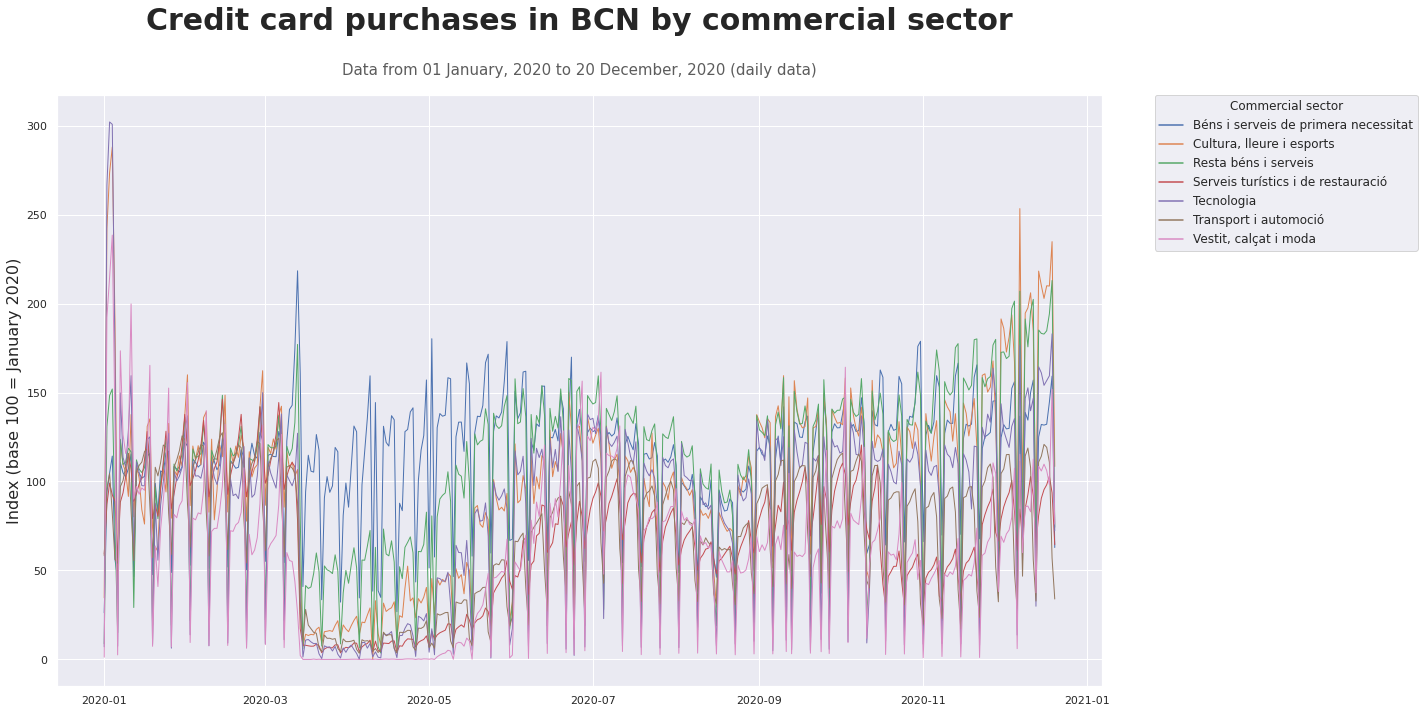

In [ ]:
visualize_timeseries('D')

Using the previous function we can also aggregate the data by month:

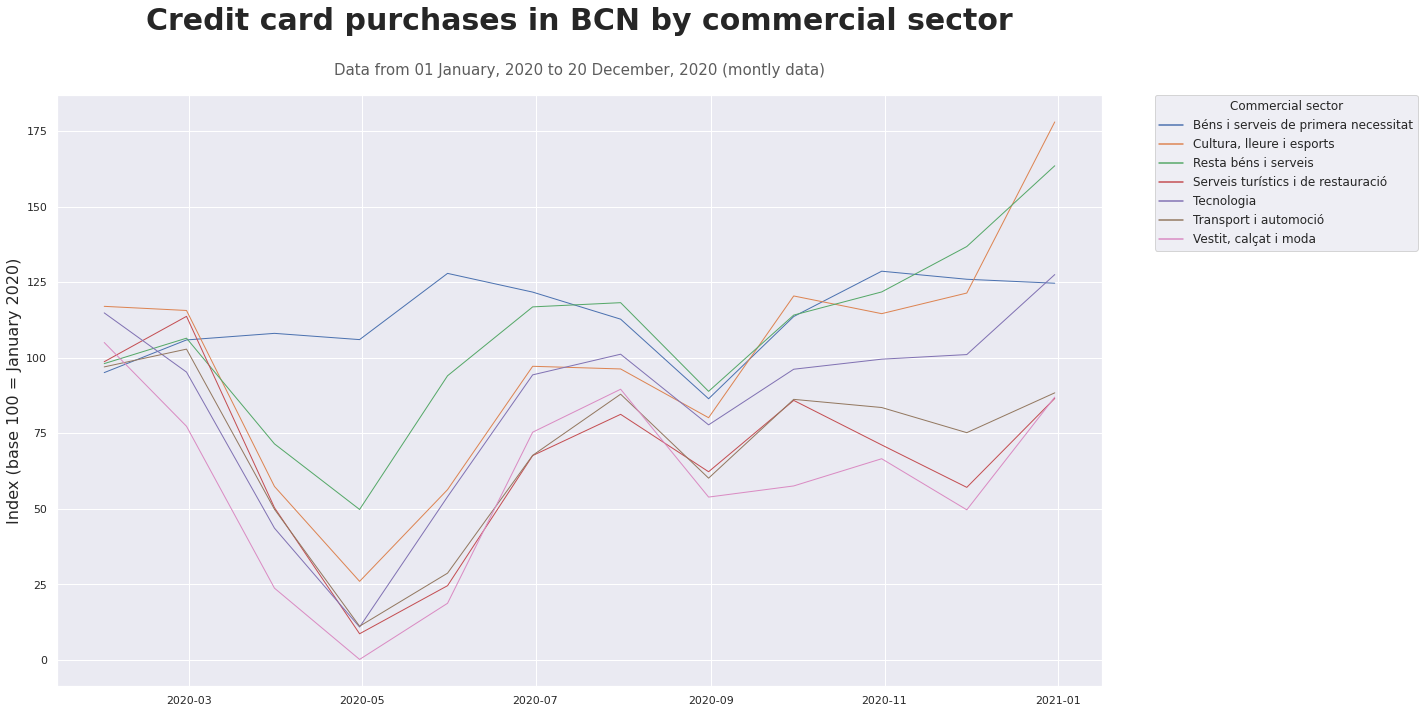

In [ ]:
visualize_timeseries('M')

To estimate the trend-cycle of the time series we can use a moving average:

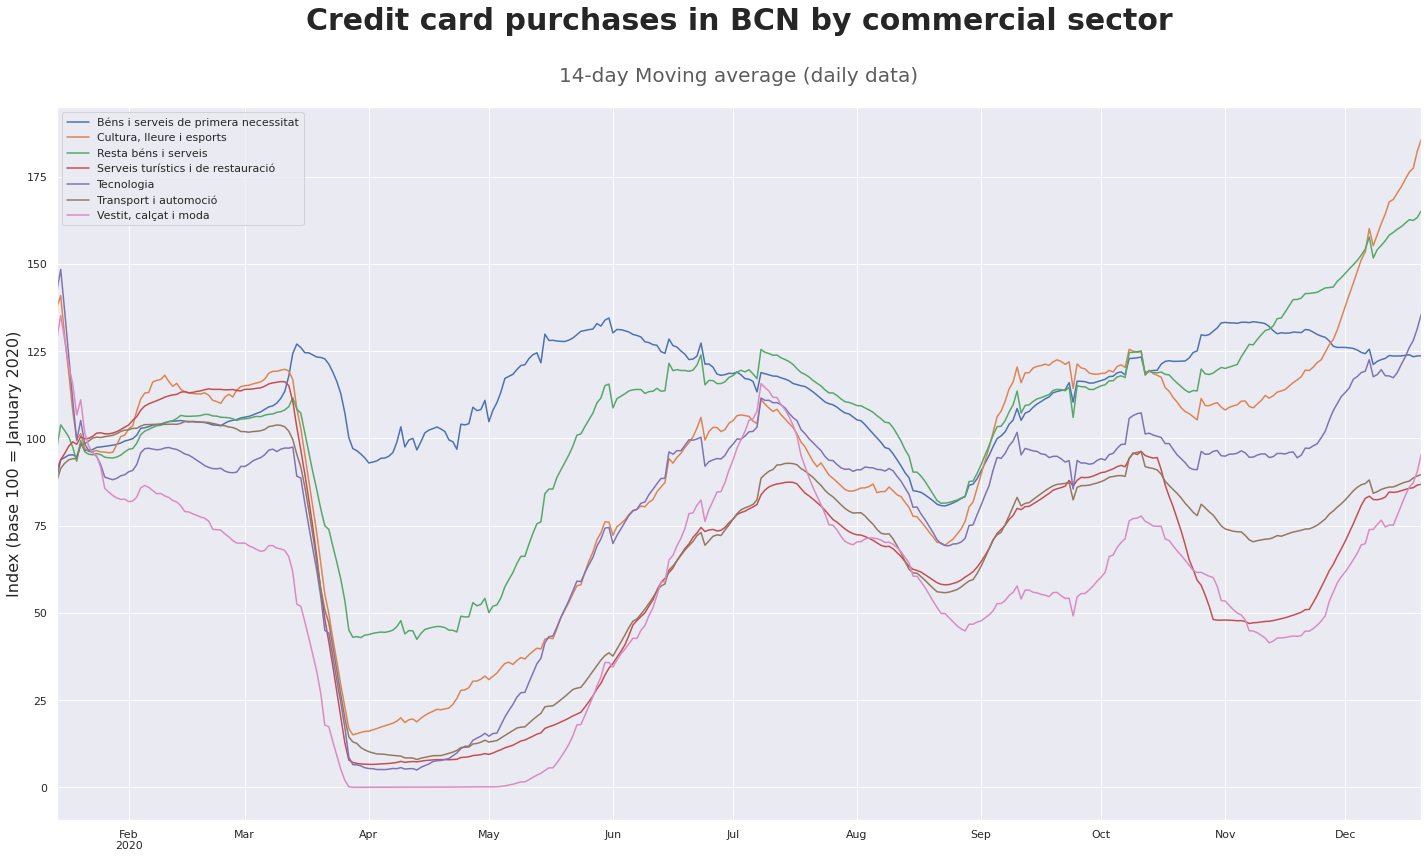

In [ ]:
PERIODS = 14 # select the periods to include in the window

fig, ax = plt.subplots(1, 1, figsize=(20,12))
for sector in df_transport['Nom_Variable'].unique(): # iterate by commercial sector
  # performing rolling mean
  ts = df_transport.loc[df_transport['Nom_Variable']==sector,[
                        'Data_Indicador', 'Valor']].set_index(
                        'Data_Indicador').rolling(window=PERIODS, 
                                                  min_periods=PERIODS).mean()
  ts.rename(columns={'Valor': sector}, inplace=True)
  ts.dropna(inplace=True) # handles nan
  ts.plot(ax=ax)

# title and subtitle
ax.text(x=0.5, y=1.1, s="Credit card purchases in BCN by commercial sector",
      fontsize=30, weight='bold', ha='center', va='bottom',
      transform=ax.transAxes)
ax.text(x=0.5, y=1.03, s=f"{PERIODS}-day Moving average (daily data)",
      fontsize=20, alpha=0.75, ha='center', va='bottom', transform=ax.transAxes)
ax.legend(title='Commercial sector', fontsize=12)

plt.xlabel('') # drop xlabel
plt.ylabel('Index (base 100 = January 2020)', fontsize=16)
plt.legend()
plt.tight_layout();

From the visualization above it can be seen how there was a very strong drop in mid-March, a smaller one during the month of August, and currently the trend is up in almost all commercial sectors.

We can also analyze the correlation between the 7 time series:



In [ ]:
# preparing data for the scatterplot and correlation matrix
df_pivot = df_transport[['Nom_Variable', 'Data_Indicador', 'Valor']].pivot_table(
    values='Valor', index='Data_Indicador', columns='Nom_Variable')

# changing name columns by numbers, original names are large
name_columns = {}
for n, sector in enumerate(df_pivot.columns):
  name_columns[sector] = n 
df_pivot.rename(columns=name_columns, inplace=True)

{'Béns i serveis de primera necessitat': 0, 'Cultura, lleure i esports': 1, 'Resta béns i serveis': 2, 'Serveis turístics i de restauració': 3, 'Tecnologia': 4, 'Transport i automoció': 5, 'Vestit, calçat i moda': 6}


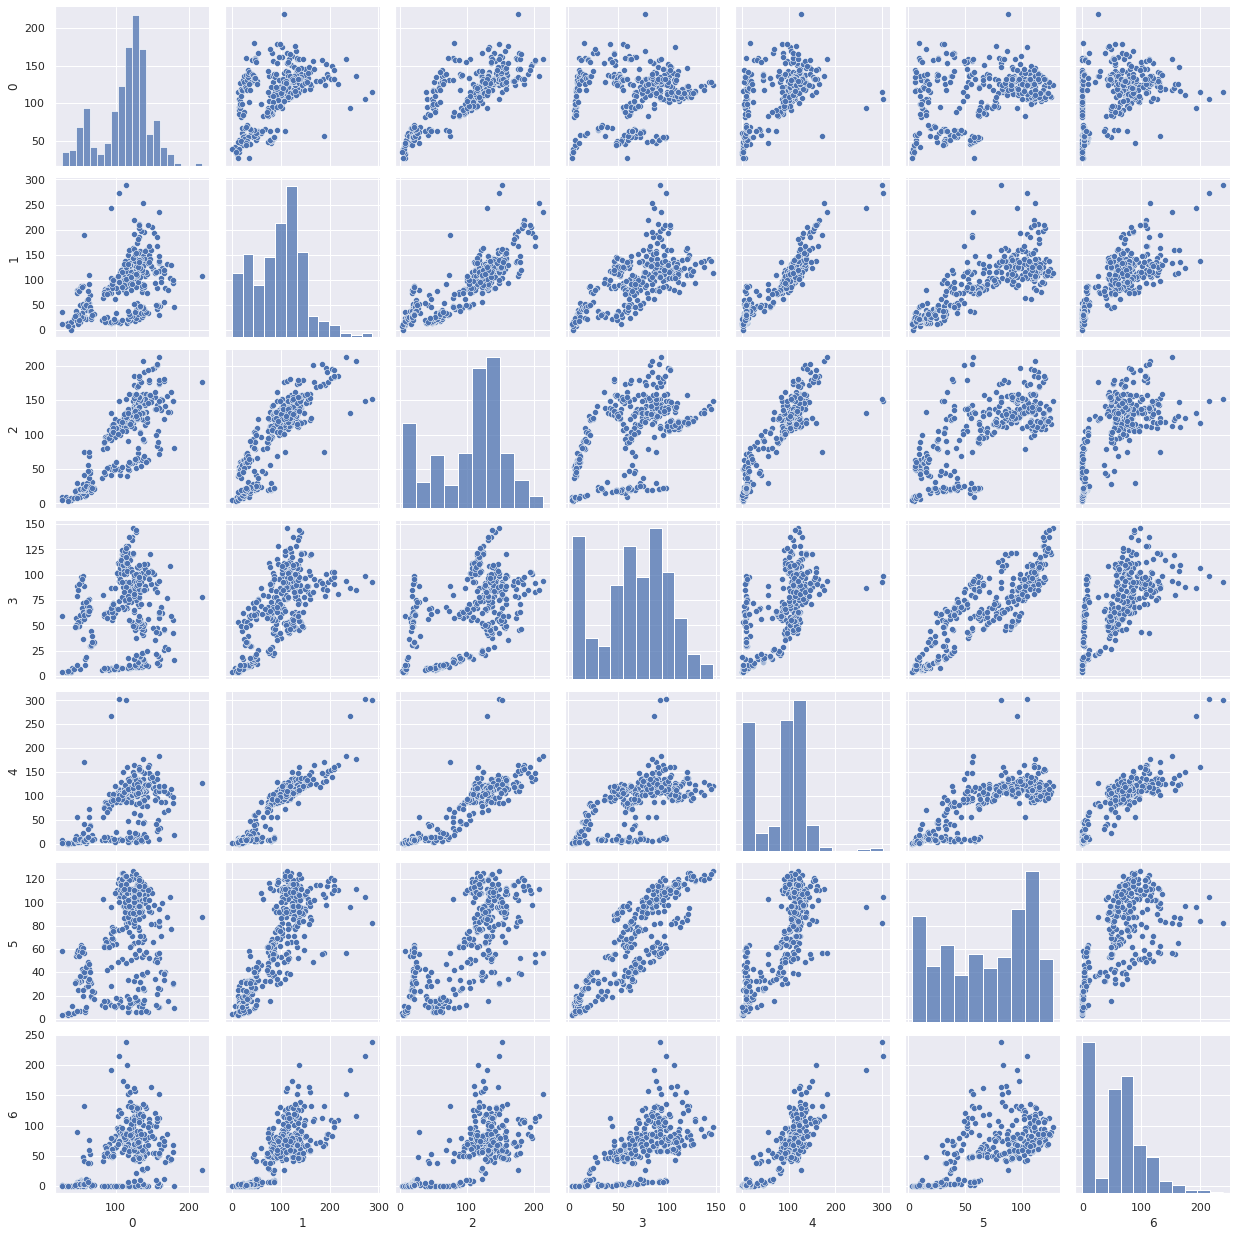

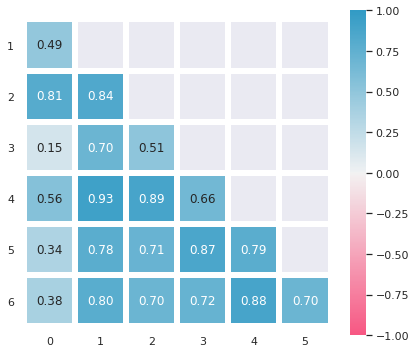

In [ ]:
# PAIRPLOT
# plotting each time series against the others
sns.pairplot(df_pivot);

# CORRELATION MATRIX
df_corr = df_pivot.corr()
# mask
mask = np.triu(np.ones_like(df_corr, dtype=np.bool))
# adjust mask and df
mask = mask[1:, :-1]
corr = df_corr.iloc[1:,:-1].copy()
# color map
cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)
# plot heatmap
fig, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", 
           linewidths=5, cmap=cmap, vmin=-1, vmax=1, 
           cbar_kws={"shrink": .8}, square=True,)
plt.yticks(rotation=0)
ax.set(xlabel="", ylabel="")
plt.tight_layout()

print(name_columns)

To see the relationship between the index and the name of the sector (sector names are too long to include in visualization):

In [ ]:
name_columns

{'Béns i serveis de primera necessitat': 0,
 'Cultura, lleure i esports': 1,
 'Resta béns i serveis': 2,
 'Serveis turístics i de restauració': 3,
 'Tecnologia': 4,
 'Transport i automoció': 5,
 'Vestit, calçat i moda': 6}

Note that the time series of the different commercial sectors are positively correlated in most cases. The series with the highest correlation are *Tecnologia* and *Cultura, lleure i esports*; whereas the series with the lowest correlation are *Serveis turístics i de restauració* and *Béns i serveis de primera necessitat*.

# PREPARING THE DATA

The forecasting will be carried out at a daily level. We will test different models (they need the data to be prepared in a different way so will be divided into different sections):

- **SARIMA** (Seasonal AutoRegressive Integrated Moving Average).
- **Gradient Boosting**.
- **LSTM** (Long short-term memory).
- **Prophet**, forecasting tool developed by Facebook.

The first step is to see if there is seasonality in the data.

In [ ]:
# aggregation by day and mode of transport and setting as index
df_agg = df_transport[['Nom_Variable','Data_Indicador','Valor']].groupby([
    pd.Grouper(key='Data_Indicador', freq='D'), 
    pd.Grouper(key='Nom_Variable')
]).mean()

print("First values of the time series:")
display(df_agg.head())
print("\nLast values of the time series:")
display(df_agg.tail())

First values of the time series:


Valor
Data_Indicador Nom_Variable                               
2020-01-01     Béns i serveis de primera necessitat  26.24
               Cultura, lleure i esports             34.61
               Resta béns i serveis                   8.75
               Serveis turístics i de restauració    59.19
               Tecnologia                             7.11


Last values of the time series:


Valor
Data_Indicador Nom_Variable                             
2020-12-20     Resta béns i serveis                74.28
               Serveis turístics i de restauració  64.49
               Tecnologia                          72.31
               Transport i automoció               33.96
               Vestit, calçat i moda               76.03

Since the five time series have similar behaviour, we choose one and perform its ETS decomposition. The decomposition of a time series attempts to isolate individual components such as error, trend, and seasonality (ETS).

When choosing between an additive or multiplicative model it is important to consider:

- *Additive model*: when the trend is more linear and the seasonality and trend components seem to be constant over time.
- *Multiplicative model*: more appropriate when we are increasing (or decreasing) at a non-linear rate.

This time, I choose an additive model. In the next plot we can see the different components of the time series, the **trend**, the **seasonality** and the **residuals**:

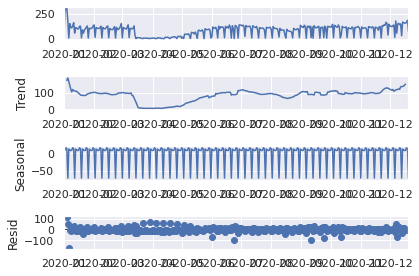

In [ ]:
# seasonal decomposition
ts = df_agg.xs('Tecnologia', level=1)
result = seasonal_decompose(ts, model='add')
result.plot();

Focusing on the seasonal plot we observe there are approximately 4/5 weeks per month, so it can be deduced that there is **weekly seasonality**:

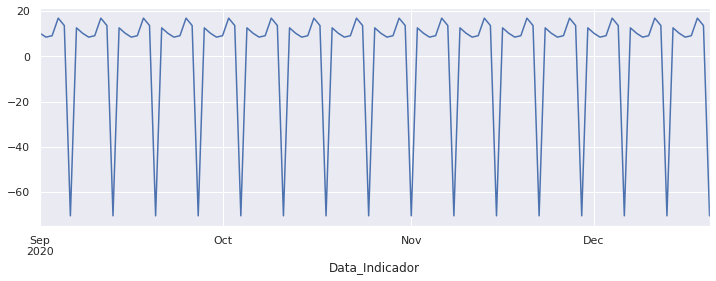

In [ ]:
result.seasonal.loc["2020-09-01":].plot(figsize=(12,4));

To be more confident, we can use a boxplot to see the distribution according to the day of the week. It can be seen how purchases decrease considerably on Sundays, so we can confirm there is a weekly seasonality:

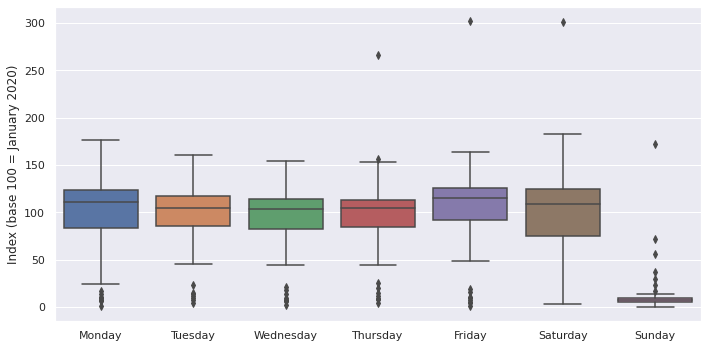

In [ ]:
ts['day_week'] = ts.index.weekday

# replacing number of week by name
dw = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
ts['day_week'] = ts['day_week'].replace({0:dw[0], 1:dw[1] ,2:dw[2],3:dw[3],
                                        4:dw[4], 5:dw[5], 6:dw[6]})

fig, ax = plt.subplots(1, 1, figsize=(10,5))
sns.boxplot(data=ts, x='day_week', y='Valor', order=dw)
ax.set(xlabel='', ylabel='Index (base 100 = January 2020)')
plt.tight_layout();

Note: If we had data from more years probably we could observe a monthly seasonality.

In [ ]:
# defining auxiliar funcitons

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def error_ts(y_true, y_pred):
    mape = mean_absolute_percentage_error(y_true, y_pred)
    rmse_result = rmse(y_true, y_pred)
    print(f"MAPE: {mape:.2f}\nRMSE: {rmse_result:.2f}")
    return mape, rmse_result

*How can we evaluate the models?*

The **accuracy** of forecasts can only be determined by considering how well a model performs on new data that were not used when fitting the model. Hence, we will consider a **test set** of the same size of the forecast (it is advisable that the test set is at least as large as the forecast). Therefore, we will be able to **evaluate and compare the models**. 

Remember because the test data is not used in determining the forecasts, it should provide a reliable indication of how well the model is likely to forecast on new data. 

Note: Actually, this test set is a validation set, since the test set should not be used to validate models or parameters. If we had more data, it would be better to do a validation set and a test set.

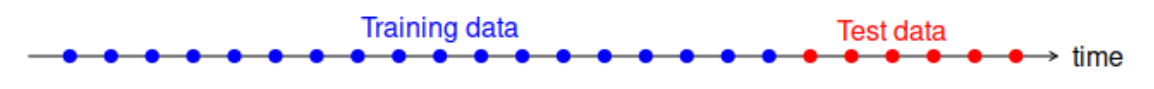

The most popular metrics to evaluate forecasting models are:

- **MAE** and **RMSE** are called *scale-dependent errors*, meaning the forecast errors are on the same scale as the data. This metrics cannot be used to make comparisons between series that involve different units.  A forecasting method that minimises the MAE will lead to forecasts of the median while minimising the RMSE will lead to forecasts of the mean. Consequently, the RMSE is also widely used, despite being more difficult to interpret.

- **MAPE** has the advantage of being unit-free and is frequently used to compare forecast performances between data sets.

To evaluate our models we will use MAPE and RMSE, and to compare the models we will use only **MAPE** since the scale of the time series is different.

In [ ]:
DAYS = 14 # select the number of days to forecast

We use the train set to train the models and the test set to evaluate the models:

In [ ]:
# dividing the train and test sets
train = ts.iloc[:-DAYS] 
test = ts.iloc[-DAYS:]

print(f"Train set, shape: {train.shape}")
display(train.head())

print(f"Test set, shape: {test.shape}")
display(test.head())

Train set, shape: (341, 2)


Valor   day_week
Data_Indicador                   
2020-01-01        7.11  Wednesday
2020-01-02      266.47   Thursday
2020-01-03      302.05     Friday
2020-01-04      300.71   Saturday
2020-01-05      171.68     Sunday

Test set, shape: (14, 2)


Valor   day_week
Data_Indicador                   
2020-12-07      176.58     Monday
2020-12-08       55.57    Tuesday
2020-12-09      146.71  Wednesday
2020-12-10      152.65   Thursday
2020-12-11      139.74     Friday

# FITTING MODELS

## SARIMA

SARIMA is based in the ARIMA model but adds a seasonal component, it's one of the main approaches when dealing with time series forecasting. The ARIMA model has 3 components:

* **AR**(p) Autoregression - a regression model that utilizes the dependent relationship between a current observation and observations over a previous period.
* **I**(d) Integration - uses differencing of observations (subtracting an observation from an observation at the previous time step) in order to make the time series stationary
* **MA**(q) Moving Average - a model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.

ARIMA performs very well when working with a time series where the data is directly related to the time stamp, our data have clear growth and seasonality based on time. It is important to keep in mind that an ARIMA model is not able to understand any outside factors if those effects are not already present in the current data.

Where ARIMA accepts the parameters  *(p,d,q)* , SARIMA accepts an additional set of parameters  *(P,D,Q)m*  that specifically describe the seasonal components of the model. Here  *P* ,  *D*  and  *Q*  represent the seasonal regression, differencing and moving average coefficients, and  m  represents the number of data points (rows) in each seasonal cycle.

It is **necessary for the data to be stationary** in order to use SARIMA or ARIMA models and select their parameters. A stationary time series is one whose properties do not depend on the time at which the series is observed. That means:

* Mean needs to be constant.
* Variance should not be a function of time.
* Covariance should no be a function of time.




To test if a series is stationary, we can use the following function based on the *Augmented Dickey-Fuller Test*:

In [ ]:
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())         
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")


Plotting the time series *Technology* we can see is not stationary, because its value depends on time. Furthermore, the Augmented Dickey-Fuller Test confirms it:

Augmented Dickey-Fuller Test: 
ADF test statistic       -1.081235
p-value                   0.722497
# lags used              17.000000
# observations          337.000000
critical value (1%)      -3.449904
critical value (5%)      -2.870155
critical value (10%)     -2.571360
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


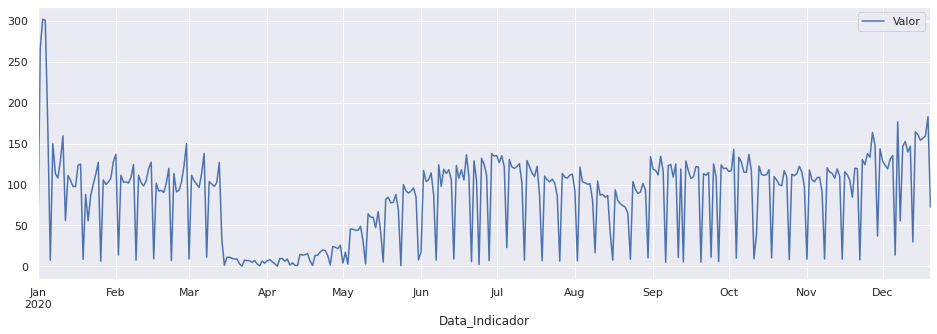

In [ ]:
ts.drop('day_week', axis=1, inplace=True)
ts.plot(figsize=(16,5));
adf_test(ts)

Once determined the data is not stationary, it is necessary to transform it to be stationary. One simple way to do this is through 'differencing'. Sometimes it is necessary to differentiate more than once to get the time series to be stationary, this would correspond to a parameter d=2 in an ARIMA model:

Augmented Dickey-Fuller Test: 
ADF test statistic       -5.200412
p-value                   0.000009
# lags used              13.000000
# observations          334.000000
critical value (1%)      -3.450081
critical value (5%)      -2.870233
critical value (10%)     -2.571401
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


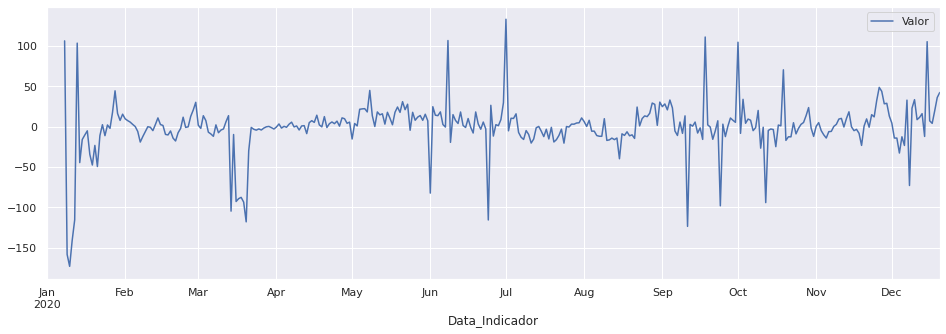

In [ ]:
# differenciate the time series
ts_diff = ts.diff(7)
# plot the time series differenciated
ts_diff.plot(figsize=(16,5)); 
# perform the Augmented Dickey-Fuller Test
adf_test(ts_diff)

*¿Once we know how many times we need to differentiate the time series (d) how we select the others parameters of the ARIMA model (p and q)?* 

We could use the approach of taking the autocorrelation plot (ACF) and the partial autocorrelation plot (PACF). PACF Plot can reveal recommended AR(p) orders, and an ACF Plot can do the same for MA(q) orders:

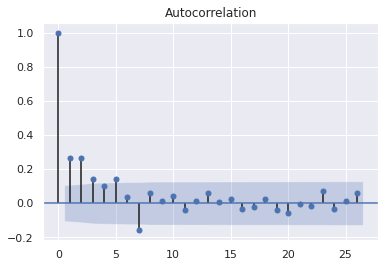

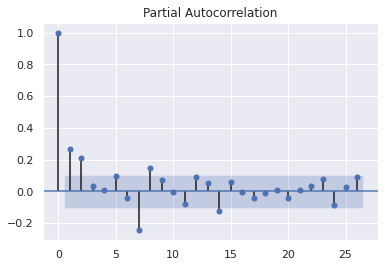

In [ ]:
plot_acf(ts_diff.dropna());
plot_pacf(ts_diff.dropna());

However, sometimes it can be very difficult to read these plots and the best performing *p,d, or q* value may be different than what is read. Therefore due to the computing power available today it is often more effective take another approach and perform a grid search across various combinations of *p,d,q* values.

The **pmdarima** (Pyramid ARIMA) is a python library designed to perform grid searches across multiple combinations of *p,d,q*, and *P,D,Q*. It is by far the most effective way to get  good models. The pmdarima library utilizes the **Akaike information criterion (AIC)** as a metric to compare the performance of various ARIMA based models. In this case, we will use the function *auto_arima* to get the best fitting terms:

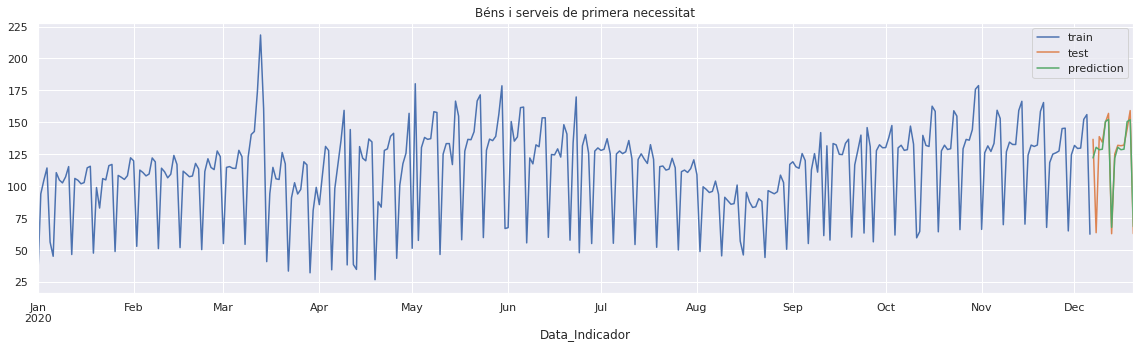

SARIMA terms: (1, 1, 1)(1, 0, 1, 7)
MAPE: 11.75
RMSE: 18.93


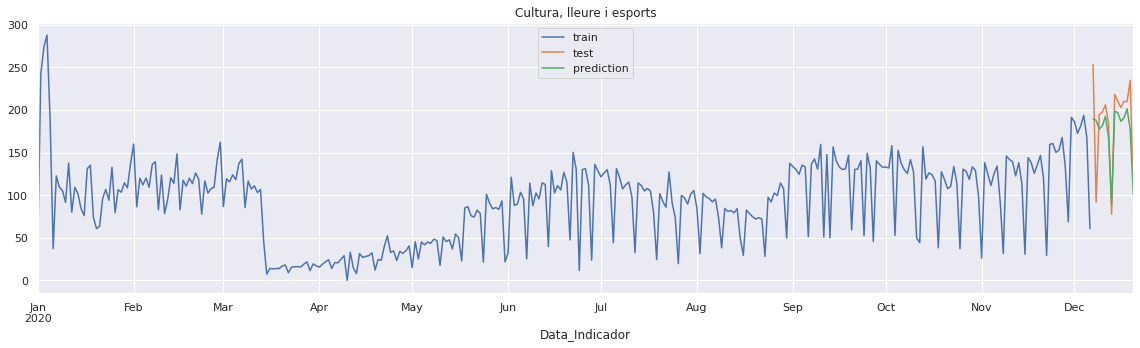

SARIMA terms: (0, 1, 1)(1, 0, 1, 7)
MAPE: 17.54
RMSE: 36.92


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



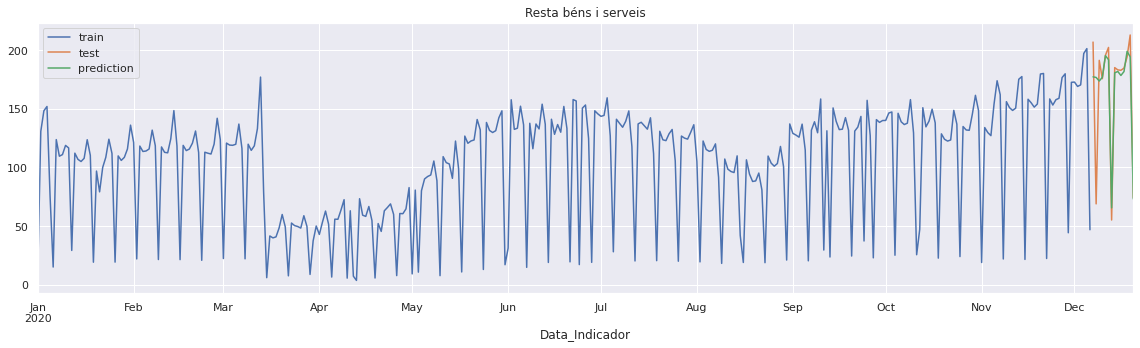

SARIMA terms: (0, 1, 2)(2, 0, 2, 7)
MAPE: 16.07
RMSE: 31.01


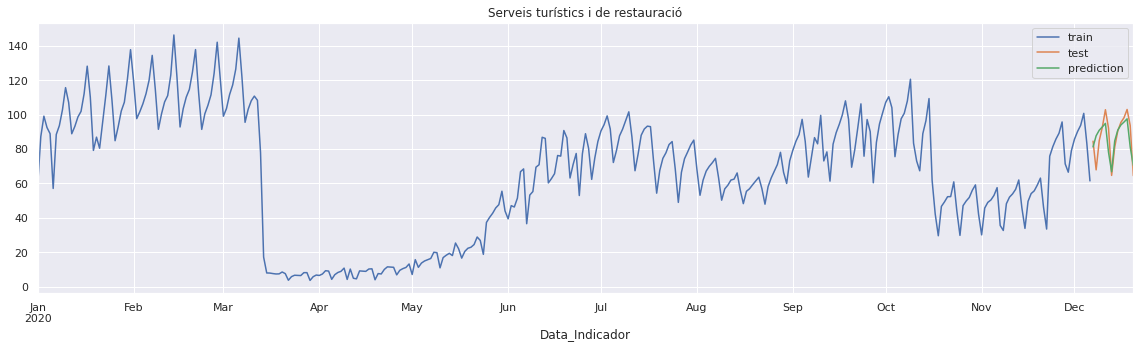

SARIMA terms: (2, 1, 3)(1, 0, 1, 7)
MAPE: 7.39
RMSE: 8.21


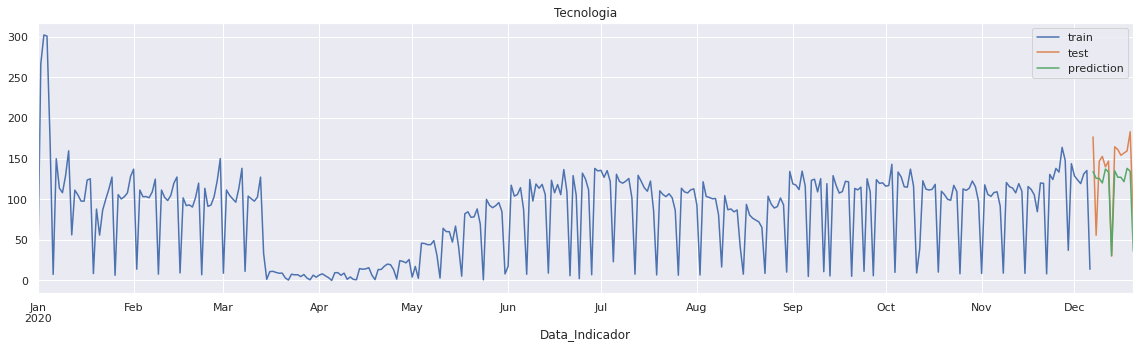

SARIMA terms: (0, 1, 1)(1, 0, 1, 7)
MAPE: 26.40
RMSE: 34.44


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



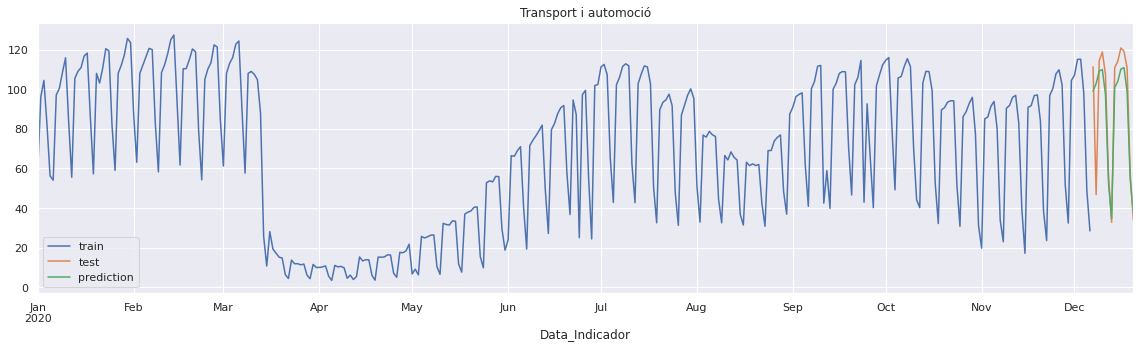

SARIMA terms: (0, 1, 2)(1, 0, 1, 7)
MAPE: 15.87
RMSE: 17.04


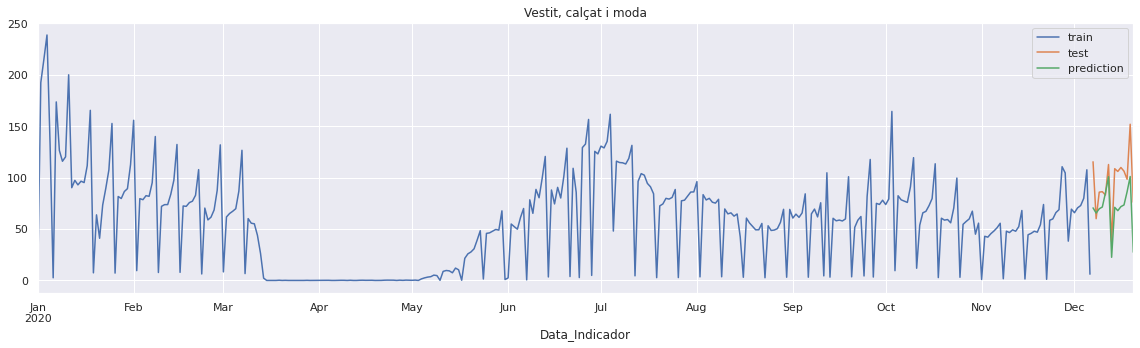

SARIMA terms: (0, 1, 2)(1, 0, 1, 7)
MAPE: 27.34
RMSE: 30.89


In [ ]:
dict_pred_sar = {} # to save predictions and metrics
dict_order_sar = {} # to save parameters

dict_times = {} # to save models execution times
l_sarima = [] # to save sarima execution times

# iterates by different modes of transport
for sector in list(df_agg.index.levels[1]):
  start_time = time.time()
  ts = df_agg.xs(sector, level=1)

  # grid seach of the best parameters
  result = auto_arima(ts, seasonal=True, m=7, n_fits=20, error_action='ignore')

  # saving best parameters  
  dict_order_sar[sector] = (result.order, result.seasonal_order)

  train = ts.iloc[:-DAYS]
  test = ts.iloc[-DAYS:]

  # SARIMA model with the best parameteres found in auto_arima
  model = SARIMAX(train, order=result.order, seasonal_order=result.seasonal_order)
  results = model.fit()

  # obtains predicted values
  start=len(train)
  end=len(train)+len(test)-1
  predictions = results.predict(start=start, end=end, dynamic=False, typ='levels', return_conf_int=True)
  # avoid predictions below zero
  predictions[predictions<0] = 0

  train.rename(columns={'Valor':'train'}, inplace=True)
  test.rename(columns={'Valor':'test'}, inplace=True)

  # plotting the time series
  fig, ax = plt.subplots(1,1, figsize=(16,5))
  train.plot(label='train', ax=ax)
  test.plot(label='test', ax=ax)
  predictions.plot(label='prediction', ax=ax)
  ax.set(title=sector)
  plt.legend()
  plt.tight_layout()
  plt.show()

  print(f"SARIMA terms: {result.order}{result.seasonal_order}")
  # evaluting predictions
  mape, rmse_result = error_ts(test.values.flatten(), predictions.values.flatten())
  print("="*20)

  # saving results and predictions
  dict_pred_sar[sector] = (predictions, [mape, rmse_result])
  l_sarima.append(time.time() - start_time)

dict_times['sarima'] = l_sarima

In [ ]:
# dictionary with mape and rsme
dict_results = {}
for mode in dict_pred_sar.keys():
    dict_results[mode] = dict_pred_sar[mode][1]
    
df_results = pd.DataFrame(dict_results).T.rename(columns={0: 'MAPE', 1:'RMSE'})
# sorting by mape
df_results.sort_values(by='MAPE', inplace=True)
df_results = df_results.add_suffix('_sarima')

The results of the SARIMA model:

In [ ]:
df_results

MAPE_sarima  RMSE_sarima
Serveis turístics i de restauració       7.391593     8.212752
Béns i serveis de primera necessitat    11.750629    18.925596
Transport i automoció                   15.873975    17.039745
Resta béns i serveis                    16.065712    31.012995
Cultura, lleure i esports               17.543530    36.916039
Tecnologia                              26.396155    34.437853
Vestit, calçat i moda                   27.343993    30.890470

## GRADIENT BOOSTING

XGBoost is an efficient implementation of gradient boosting for classification and regression problems. XGBoost can also be used for time series forecasting, although it requires that the time series dataset be transformed into a supervised learning problem first. 

Therefore for each observation of our dataset we add a new feature with the day, day of the week, week and month:

In [ ]:
  # adding features as columns
  ts['month'] = ts.index.month
  ts['day'] = ts.index.day
  ts['week'] = ts.index.isocalendar().week
  ts['week_day'] = ts.index.weekday
  display(ts.head())
  display(ts.tail())

Valor  month  day  week  week_day
Data_Indicador                                    
2020-01-01        1.26      1    1     1         2
2020-01-02      192.16      1    2     1         3
2020-01-03      214.78      1    3     1         4
2020-01-04      238.46      1    4     1         5
2020-01-05      132.38      1    5     1         6

Valor  month  day  week  week_day
Data_Indicador                                    
2020-12-16      109.74     12   16    51         2
2020-12-17      106.15     12   17    51         3
2020-12-18       98.30     12   18    51         4
2020-12-19      151.73     12   19    51         5
2020-12-20       76.03     12   20    51         6

We get our matrix of features and the vector of target values:

In [ ]:
X, y = ts.drop('Valor', axis=1), ts['Valor']
print("Features:")
display(X.head())
print("\nTarget:")
display(y.head())

Features:


month  day  week  week_day
Data_Indicador                            
2020-01-01          1    1     1         2
2020-01-02          1    2     1         3
2020-01-03          1    3     1         4
2020-01-04          1    4     1         5
2020-01-05          1    5     1         6


Target:


Data_Indicador
2020-01-01      1.26
2020-01-02    192.16
2020-01-03    214.78
2020-01-04    238.46
2020-01-05    132.38
Freq: D, Name: Valor, dtype: float64

[14:51:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


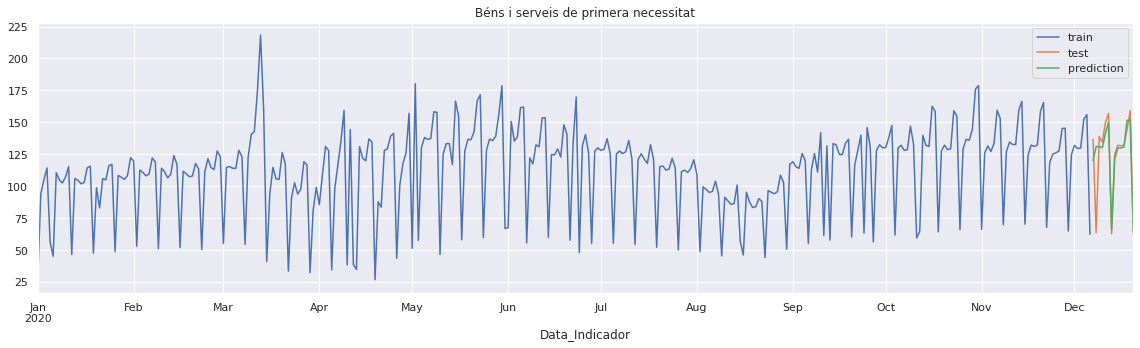

MAPE: 11.60
RMSE: 19.21
[14:51:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


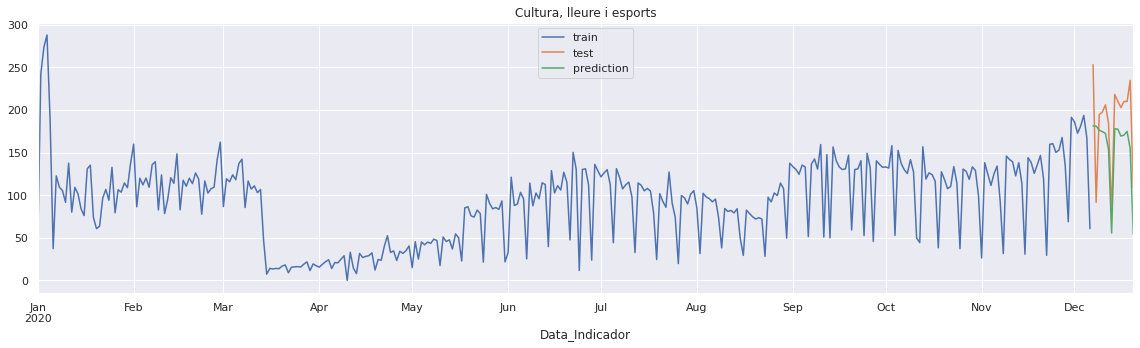

MAPE: 27.03
RMSE: 48.23
[14:51:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


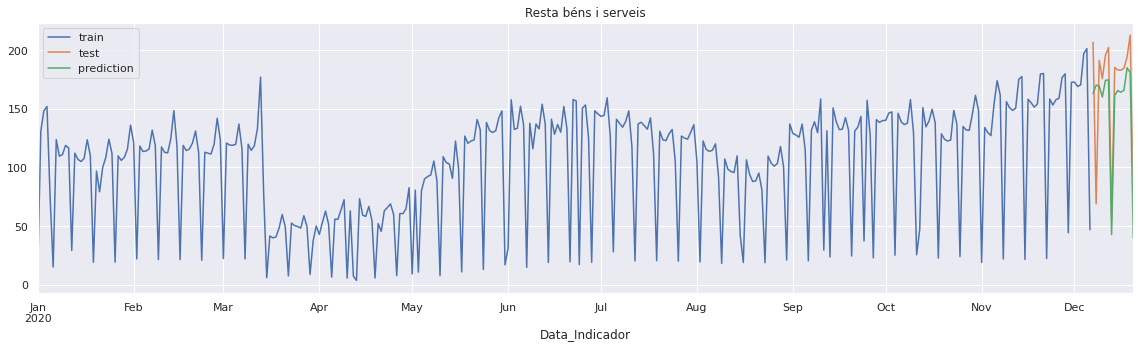

MAPE: 24.66
RMSE: 36.06
[14:51:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


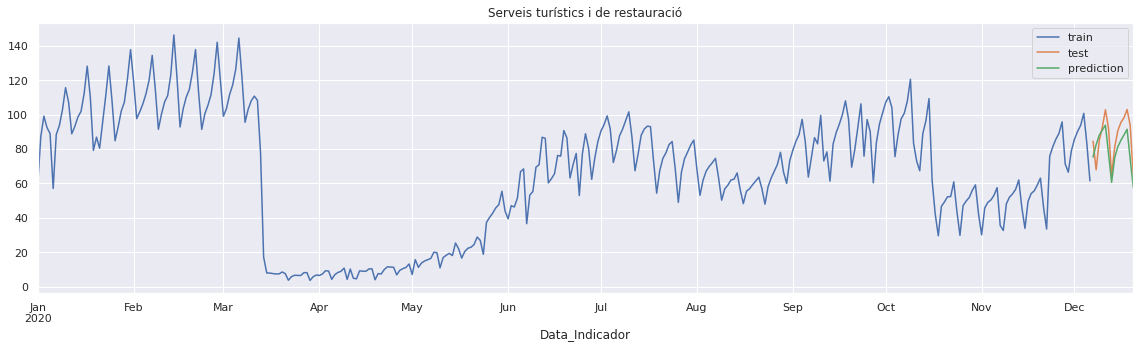

MAPE: 10.74
RMSE: 10.41
[14:51:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


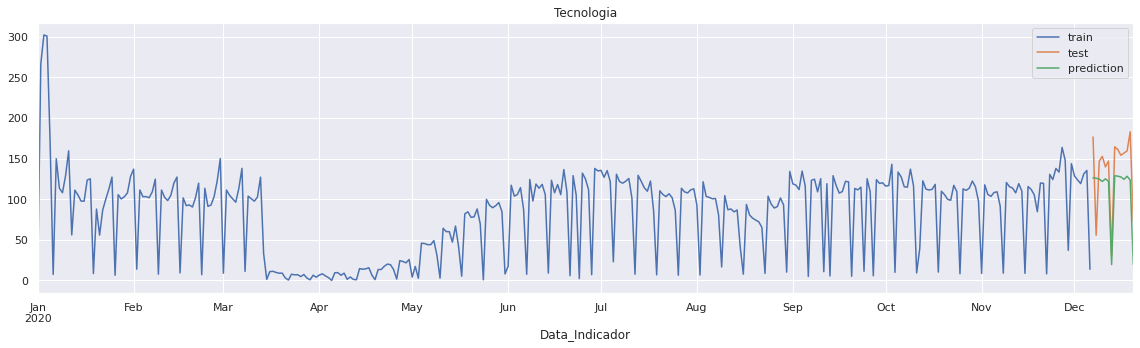

MAPE: 32.65
RMSE: 38.93
[14:51:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


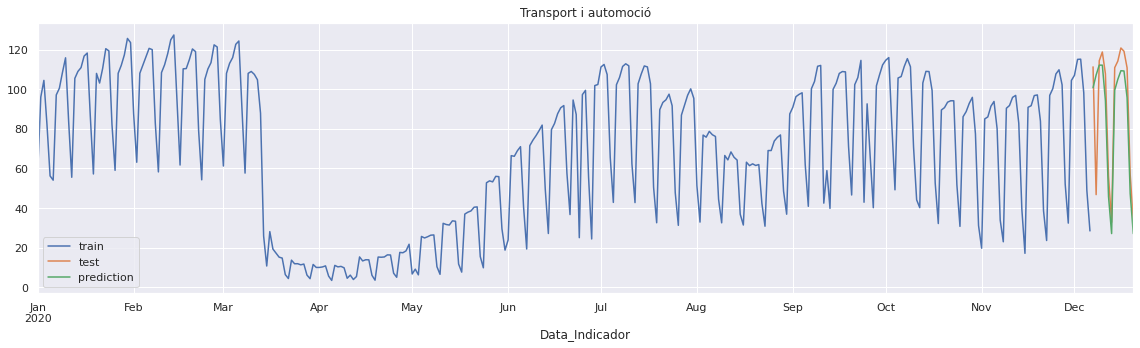

MAPE: 20.10
RMSE: 18.80
[14:51:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


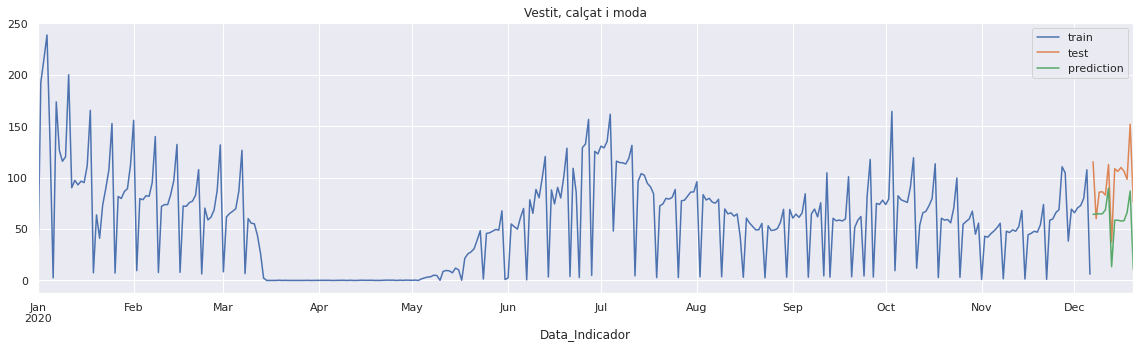

MAPE: 39.22
RMSE: 41.54


In [ ]:
# dictionary to save the results and predictions
dict_pred_ml = {}
l_xgboost = []


# iterate by different modes of transport
for sector in list(df_agg.index.levels[1]):
  start_time = time.time()
  ts = df_agg.xs(sector, level=1)
  # adding features
  ts['month'] = ts.index.month
  ts['day'] = ts.index.day
  ts['week'] = ts.index.isocalendar().week
  ts['week_day'] = ts.index.weekday

  ts['week'] = ts['week'].astype('int')


  train = ts.iloc[:-DAYS]
  test = ts.iloc[-DAYS:]

  X_train, y_train = train.drop('Valor', axis=1), train['Valor']
  X_test, y_test = test.drop('Valor', axis=1), test['Valor']    

  # fitting the model
  model = xgb.XGBRegressor(random_state=42).fit(X_train, y_train)
  predictions = model.predict(X_test)
  predictions = pd.Series(predictions, index=test.index)

  # plot the result
  fig, ax = plt.subplots(1,1, figsize=(16,5))
  y_train.plot(label='train', ax=ax)
  y_test.plot(label='test', ax=ax)
  predictions.plot(label='prediction', ax=ax)
  ax.set(title=sector)
  plt.legend()
  plt.tight_layout()
  plt.show()

  mape, rmse_result = error_ts(y_test, predictions)
  print("="*20)

  dict_pred_ml[sector] = (predictions, [mape, rmse_result])
  l_xgboost.append(time.time() - start_time)
dict_times['xgboost'] = l_xgboost

In [ ]:
# dictionary with mape and rsme
dict_results_ml = {}
for sector in dict_pred_ml.keys():
    dict_results_ml[sector] = dict_pred_ml[sector][1]
    
df_results_ml = pd.DataFrame(dict_results_ml).T.rename(columns={0: 'MAPE', 1:'RMSE'})
df_results_ml.sort_values(by='MAPE', inplace=True)
df_results_ml = df_results_ml.add_suffix('_xgboost')

The results of the gradient boosting model:

In [ ]:
df_results_ml

MAPE_xgboost  RMSE_xgboost
Serveis turístics i de restauració       10.743944     10.414671
Béns i serveis de primera necessitat     11.601232     19.207629
Transport i automoció                    20.102113     18.798489
Resta béns i serveis                     24.657531     36.056289
Cultura, lleure i esports                27.034142     48.233868
Tecnologia                               32.650093     38.927517
Vestit, calçat i moda                    39.223614     41.544335

## LSTM

Long short-term memory (LSTM) is an artificial recurrent neural network (RNN) architecture used in the field of deep learning. The LSTM cell was created to help address RNN issues when dealing with time series, for instance a RNN will begin to "forget" the first inputs after a while, as information is lost at each step going through the RNN.

I will use the class *TimeseriesGenerator* from Keras, that takes in a sequence of data-points gathered at equal intervals, along with time series parameters such as stride, length of history, etc., to produce batches for training/validation.

In order to choose the number of cells in the LSTM I had test different values and I have choosen the best performing one in the test set.






In [ ]:
def rnn_predictions(test, train_scaled, model, scaler):
  """
  Given a trained Keras model, it produces produces n predictions, where
  n = len(test).
  
  """

  test_predictions = []
  first_eval_batch = train_scaled[-n_input:]
  current_batch = first_eval_batch.reshape((1, n_input, n_features))

  for i in range(len(test)): 
      
      # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
      current_pred = model.predict(current_batch)[0]
      
      # store prediction
      test_predictions.append(current_pred) 
      
      # update batch to now include prediction and drop first value
      current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

  predictions = scaler.inverse_transform(test_predictions)
  predictions = pd.Series(predictions.flatten(), index=test.index)

  return predictions

Epoch 1/50
334/334 [==============================] - 9s 22ms/step - loss: 0.0809
Epoch 2/50
334/334 [==============================] - 8s 24ms/step - loss: 0.0289
Epoch 3/50
334/334 [==============================] - 8s 24ms/step - loss: 0.0191
Epoch 4/50
334/334 [==============================] - 8s 24ms/step - loss: 0.0172
Epoch 5/50
334/334 [==============================] - 8s 24ms/step - loss: 0.0149
Epoch 6/50
334/334 [==============================] - 7s 22ms/step - loss: 0.0135
Epoch 7/50
334/334 [==============================] - 8s 24ms/step - loss: 0.0154
Epoch 8/50
334/334 [==============================] - 8s 23ms/step - loss: 0.0109
Epoch 9/50
334/334 [==============================] - 8s 22ms/step - loss: 0.0100
Epoch 10/50
334/334 [==============================] - 7s 22ms/step - loss: 0.0123
Epoch 11/50
334/334 [==============================] - 8s 25ms/step - loss: 0.0122
Epoch 12/50
334/334 [==============================] - 8s 23ms/step - loss: 0.0112
Epoch 13/50
3

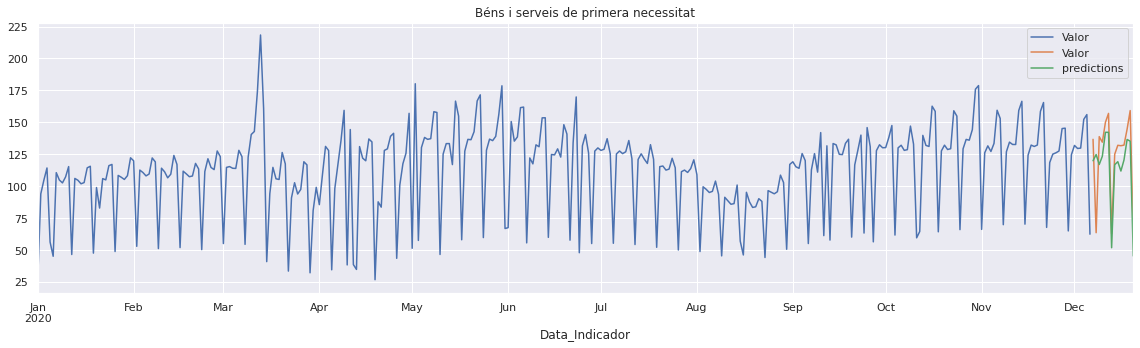

MAPE: 18.07
RMSE: 21.92
Epoch 1/50
334/334 [==============================] - 9s 23ms/step - loss: 0.0599
Epoch 2/50
334/334 [==============================] - 8s 22ms/step - loss: 0.0167
Epoch 3/50
334/334 [==============================] - 8s 23ms/step - loss: 0.0156
Epoch 4/50
334/334 [==============================] - 7s 22ms/step - loss: 0.0123
Epoch 5/50
334/334 [==============================] - 8s 25ms/step - loss: 0.0118
Epoch 6/50
334/334 [==============================] - 8s 23ms/step - loss: 0.0098
Epoch 7/50
334/334 [==============================] - 8s 25ms/step - loss: 0.0085
Epoch 8/50
334/334 [==============================] - 8s 25ms/step - loss: 0.0092
Epoch 9/50
334/334 [==============================] - 8s 23ms/step - loss: 0.0090
Epoch 10/50
334/334 [==============================] - 8s 23ms/step - loss: 0.0077
Epoch 11/50
334/334 [==============================] - 8s 24ms/step - loss: 0.0081
Epoch 12/50
334/334 [==============================] - 8s 24ms/step - lo

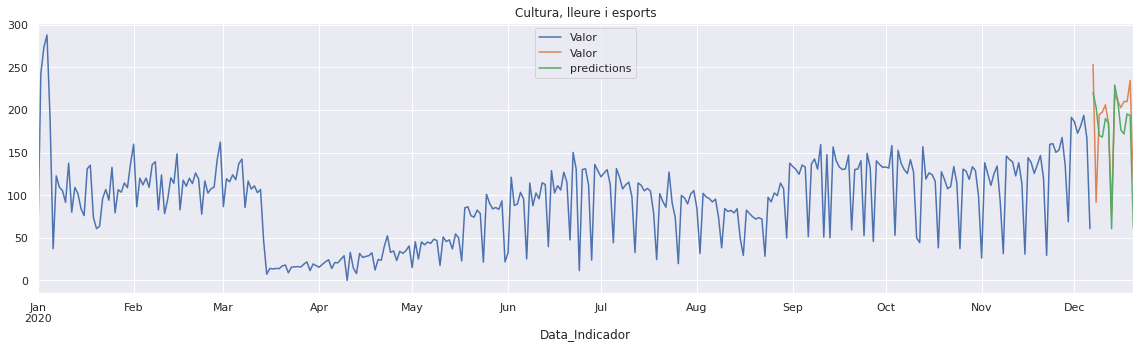

MAPE: 21.08
RMSE: 39.44
Epoch 1/50
334/334 [==============================] - 9s 23ms/step - loss: 0.1254
Epoch 2/50
334/334 [==============================] - 7s 22ms/step - loss: 0.0358
Epoch 3/50
334/334 [==============================] - 8s 23ms/step - loss: 0.0232
Epoch 4/50
334/334 [==============================] - 8s 24ms/step - loss: 0.0241
Epoch 5/50
334/334 [==============================] - 9s 26ms/step - loss: 0.0208
Epoch 6/50
334/334 [==============================] - 8s 24ms/step - loss: 0.0227
Epoch 7/50
334/334 [==============================] - 8s 23ms/step - loss: 0.0147
Epoch 8/50
334/334 [==============================] - 7s 22ms/step - loss: 0.0155
Epoch 9/50
334/334 [==============================] - 7s 22ms/step - loss: 0.0147
Epoch 10/50
334/334 [==============================] - 9s 27ms/step - loss: 0.0272
Epoch 11/50
334/334 [==============================] - 8s 23ms/step - loss: 0.0158
Epoch 12/50
334/334 [==============================] - 8s 24ms/step - lo

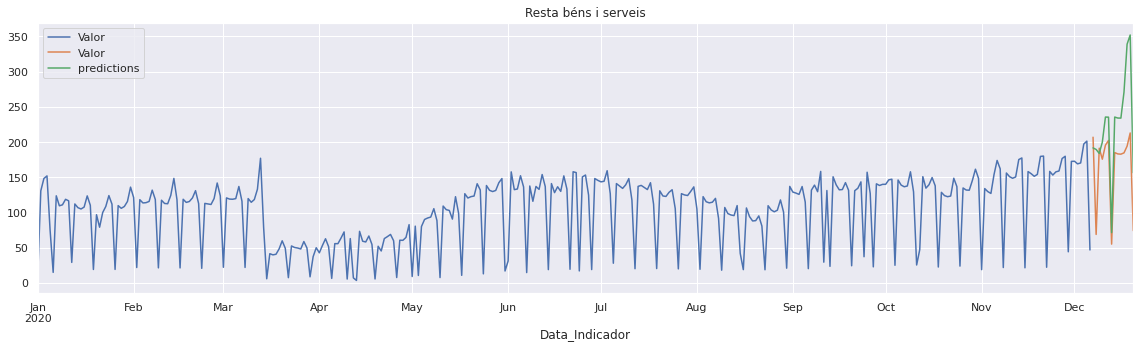

MAPE: 46.20
RMSE: 75.90
Epoch 1/50
334/334 [==============================] - 9s 23ms/step - loss: 0.0480
Epoch 2/50
334/334 [==============================] - 7s 22ms/step - loss: 0.0092
Epoch 3/50
334/334 [==============================] - 8s 23ms/step - loss: 0.0114
Epoch 4/50
334/334 [==============================] - 8s 23ms/step - loss: 0.0083
Epoch 5/50
334/334 [==============================] - 7s 22ms/step - loss: 0.0083
Epoch 6/50
334/334 [==============================] - 8s 22ms/step - loss: 0.0083
Epoch 7/50
334/334 [==============================] - 8s 24ms/step - loss: 0.0096
Epoch 8/50
334/334 [==============================] - 8s 24ms/step - loss: 0.0065
Epoch 9/50
334/334 [==============================] - 9s 26ms/step - loss: 0.0086
Epoch 10/50
334/334 [==============================] - 8s 23ms/step - loss: 0.0070
Epoch 11/50
334/334 [==============================] - 8s 25ms/step - loss: 0.0080
Epoch 12/50
334/334 [==============================] - 7s 22ms/step - lo

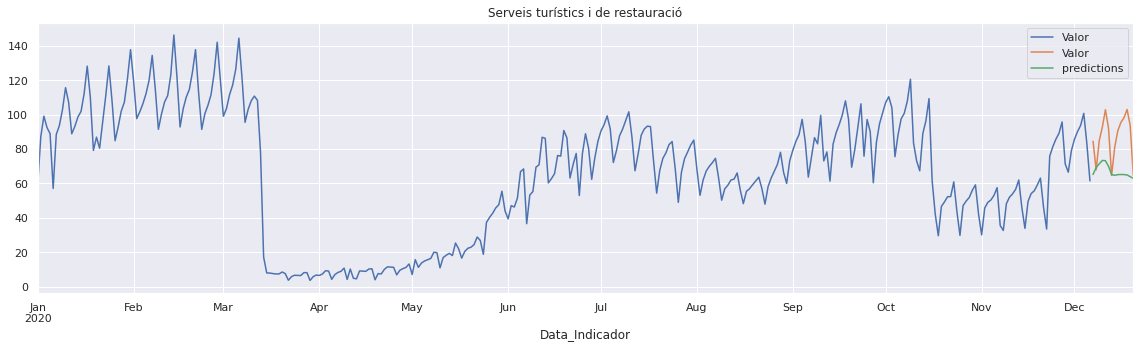

MAPE: 21.41
RMSE: 23.22
Epoch 1/50
334/334 [==============================] - 9s 22ms/step - loss: 0.0482
Epoch 2/50
334/334 [==============================] - 8s 24ms/step - loss: 0.0228
Epoch 3/50
334/334 [==============================] - 7s 22ms/step - loss: 0.0126
Epoch 4/50
334/334 [==============================] - 8s 24ms/step - loss: 0.0101
Epoch 5/50
334/334 [==============================] - 8s 25ms/step - loss: 0.0075
Epoch 6/50
334/334 [==============================] - 7s 21ms/step - loss: 0.0055
Epoch 7/50
334/334 [==============================] - 7s 22ms/step - loss: 0.0065
Epoch 8/50
334/334 [==============================] - 7s 22ms/step - loss: 0.0079
Epoch 9/50
334/334 [==============================] - 8s 25ms/step - loss: 0.0064
Epoch 10/50
334/334 [==============================] - 7s 22ms/step - loss: 0.0057
Epoch 11/50
334/334 [==============================] - 8s 24ms/step - loss: 0.0084
Epoch 12/50
334/334 [==============================] - 8s 24ms/step - lo

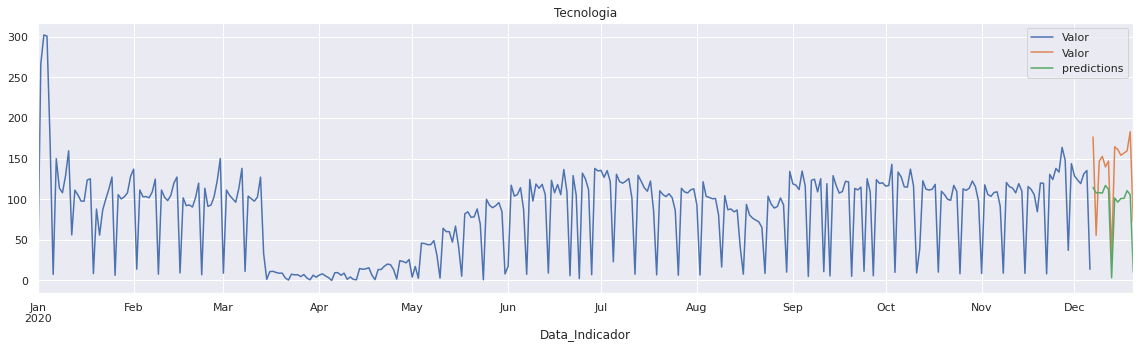

MAPE: 44.42
RMSE: 52.73
Epoch 1/50
334/334 [==============================] - 10s 25ms/step - loss: 0.0793
Epoch 2/50
334/334 [==============================] - 8s 24ms/step - loss: 0.0340
Epoch 3/50
334/334 [==============================] - 8s 24ms/step - loss: 0.0291
Epoch 4/50
334/334 [==============================] - 8s 24ms/step - loss: 0.0283
Epoch 5/50
334/334 [==============================] - 8s 25ms/step - loss: 0.0159
Epoch 6/50
334/334 [==============================] - 9s 26ms/step - loss: 0.0168
Epoch 7/50
334/334 [==============================] - 8s 25ms/step - loss: 0.0202
Epoch 8/50
334/334 [==============================] - 8s 25ms/step - loss: 0.0157
Epoch 9/50
334/334 [==============================] - 8s 24ms/step - loss: 0.0183
Epoch 10/50
334/334 [==============================] - 8s 25ms/step - loss: 0.0131
Epoch 11/50
334/334 [==============================] - 8s 24ms/step - loss: 0.0147
Epoch 12/50
334/334 [==============================] - 7s 22ms/step - l

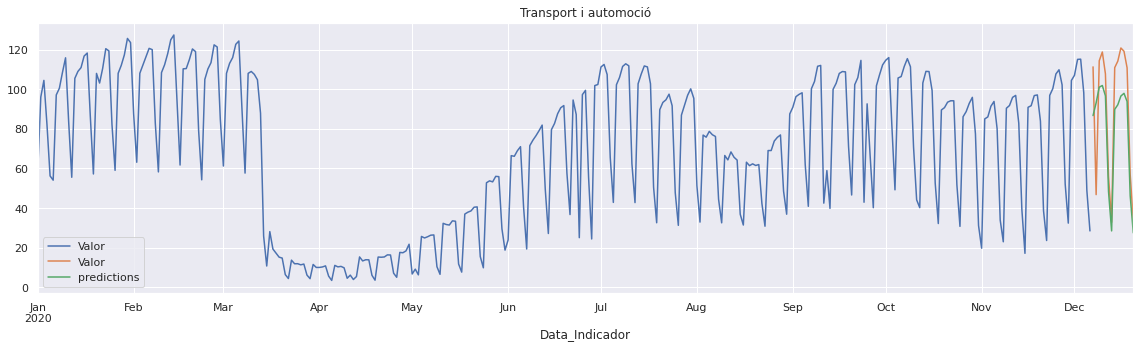

MAPE: 22.43
RMSE: 20.42
Epoch 1/50
334/334 [==============================] - 9s 23ms/step - loss: 0.0416
Epoch 2/50
334/334 [==============================] - 8s 23ms/step - loss: 0.0206
Epoch 3/50
334/334 [==============================] - 8s 23ms/step - loss: 0.0123
Epoch 4/50
334/334 [==============================] - 8s 23ms/step - loss: 0.0130
Epoch 5/50
334/334 [==============================] - 8s 24ms/step - loss: 0.0078
Epoch 6/50
334/334 [==============================] - 9s 26ms/step - loss: 0.0074
Epoch 7/50
334/334 [==============================] - 8s 23ms/step - loss: 0.0084
Epoch 8/50
334/334 [==============================] - 7s 21ms/step - loss: 0.0093
Epoch 9/50
334/334 [==============================] - 7s 22ms/step - loss: 0.0063
Epoch 10/50
334/334 [==============================] - 7s 22ms/step - loss: 0.0062
Epoch 11/50
334/334 [==============================] - 8s 23ms/step - loss: 0.0068
Epoch 12/50
334/334 [==============================] - 8s 23ms/step - lo

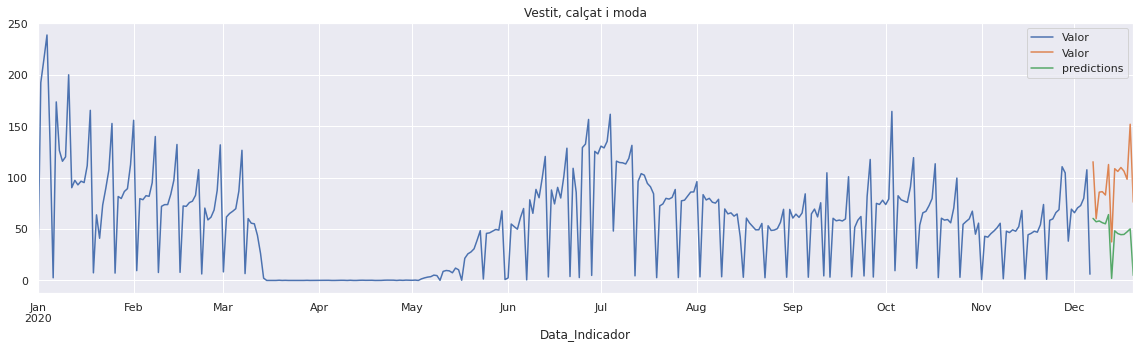

MAPE: 52.47
RMSE: 55.08


In [ ]:
# dictionaries to save the results and predictions
dict_pred_lstm = {}
dict_keras_models = {}
l_lstm = []

# iterate by different modes of transport
for i, sector in enumerate(list(df_agg.index.levels[1])):
  start_time = time.time()
  ts = df_agg.xs(sector, level=1)

  # split the time series in train and test sets
  samples = DAYS
  train = ts.iloc[:-samples]
  test = ts.iloc[-samples:]

  # scale the data
  scaler = MinMaxScaler()
  scaled_train = scaler.fit_transform(train) # fit only training data
  scaled_test = scaler.transform(test)
  
  # definining the generator
  # predict the following value based on the previous n_input values
  n_input = 7
  n_features = 1 # in forecasting always equal to 1
  generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

  # defining the model
  units = 128 # number of cells
  inputs = Input((n_input, n_features)) 
  h0 = LSTM(units, activation='selu', kernel_initializer='lecun_normal')(inputs)
  preds = Dense(1)(h0)

  keras_model = Model(inputs=inputs, outputs=preds)
  keras_model.compile(optimizer=Nadam(), loss='mse')
  # training the model
  history = keras_model.fit(generator, epochs=50, verbose=1)

  # load the model
  # keras_model = load_model(f"/content/drive/MyDrive/Colab Notebooks/datasets/opendatabcn/models/{i}-{DAYS}-{units}-forcast")
  # predicting
  predictions = rnn_predictions(test, scaled_train, keras_model, scaler)
  
  # plot results
  fig, ax = plt.subplots(1,1, figsize=(16,5))
  train.plot(label='train', ax=ax)
  test.plot(label='test', ax=ax)
  predictions.plot(label='predictions', ax=ax)
  ax.set(title=sector)
  plt.legend()
  plt.tight_layout()
  plt.show()
  
  # evaluating the model
  mape, rmse_result = error_ts(test.values.flatten(), predictions)
  print("="*20)
  
  dict_pred_lstm[sector] = (predictions, [mape, rmse_result])
  dict_keras_models[sector] = keras_model

  # keras_model.save(f"/content/drive/MyDrive/Colab Notebooks/datasets/opendatabcn/models/{i}-{DAYS}-{units}-forcast")
  l_lstm.append(time.time() - start_time)

dict_times['lstm'] = l_lstm

In [ ]:
# dictionary with mape and rsme
dict_results_lstm = {}
for sector in dict_pred_lstm.keys():
    dict_results_lstm[sector] = dict_pred_lstm[sector][1]
    
df_results_lstm = pd.DataFrame(dict_results_lstm).T.rename(columns={0: 'MAPE', 1:'RMSE'})
df_results_lstm.sort_values(by='MAPE', inplace=True)
df_results_lstm = df_results_lstm.add_suffix('_lstm')

The results of the LSTM:

In [ ]:
df_results_lstm

MAPE_lstm  RMSE_lstm
Béns i serveis de primera necessitat  18.073922  21.919734
Cultura, lleure i esports             21.077020  39.444742
Serveis turístics i de restauració    21.405952  23.219643
Transport i automoció                 22.428176  20.421335
Tecnologia                            44.423658  52.732009
Resta béns i serveis                  46.198169  75.895297
Vestit, calçat i moda                 52.469512  55.084808

## PROPHET

Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


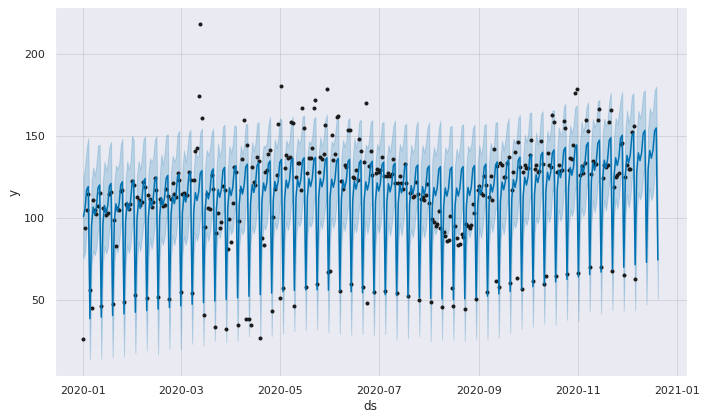

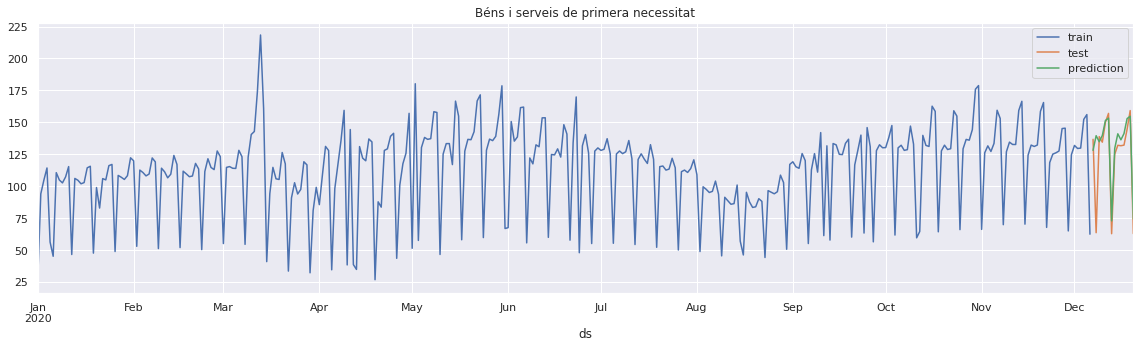

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAPE: 14.24
RMSE: 21.43


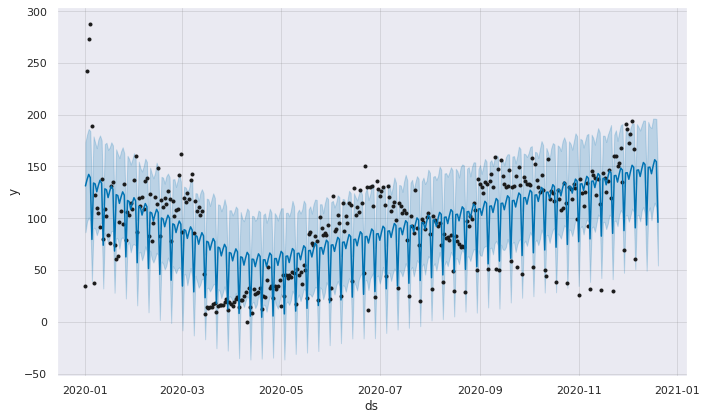

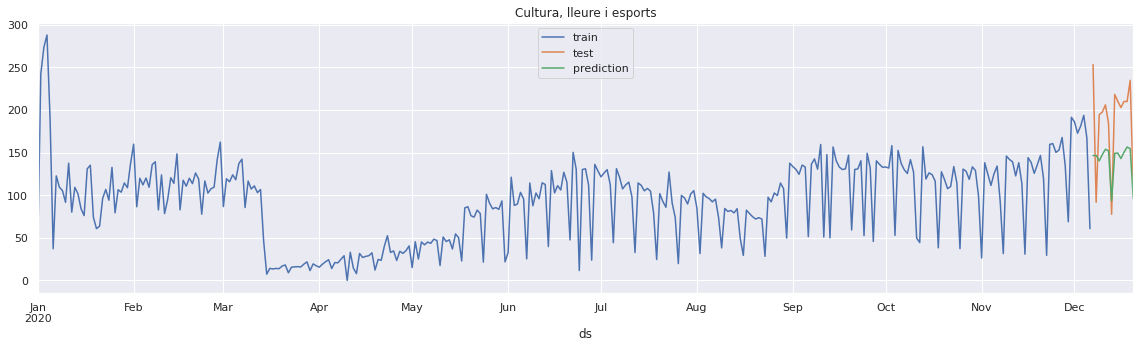

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAPE: 29.15
RMSE: 59.13


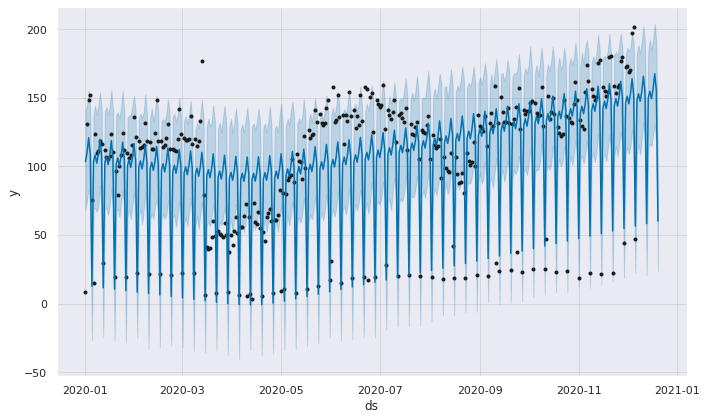

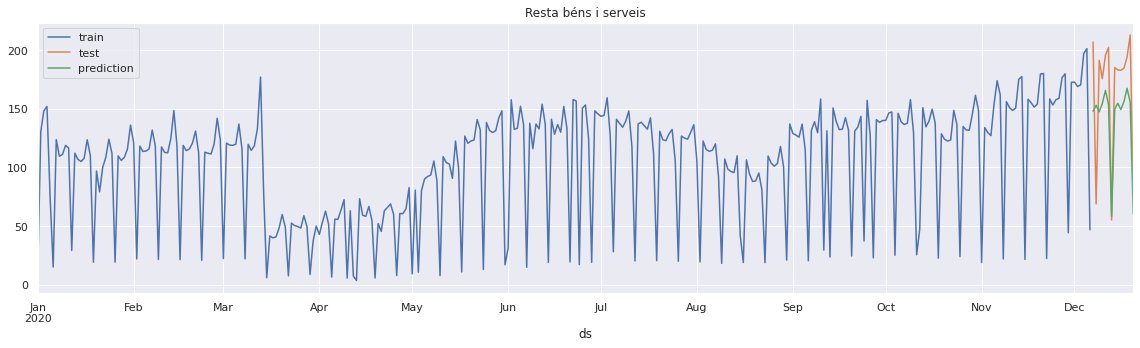

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAPE: 25.61
RMSE: 41.72


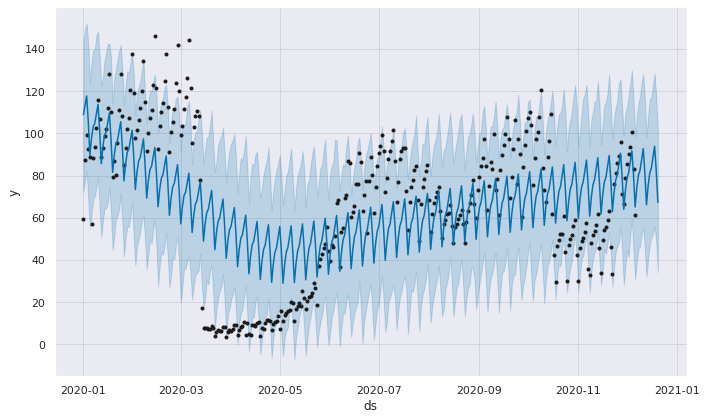

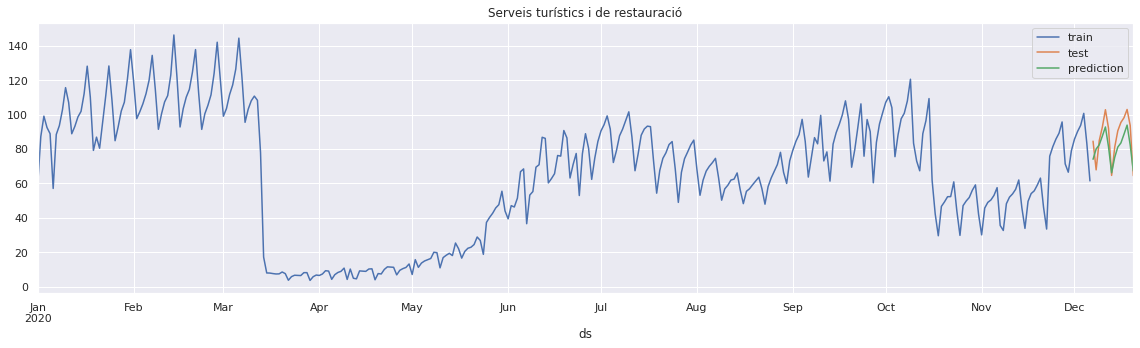

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAPE: 9.13
RMSE: 8.81


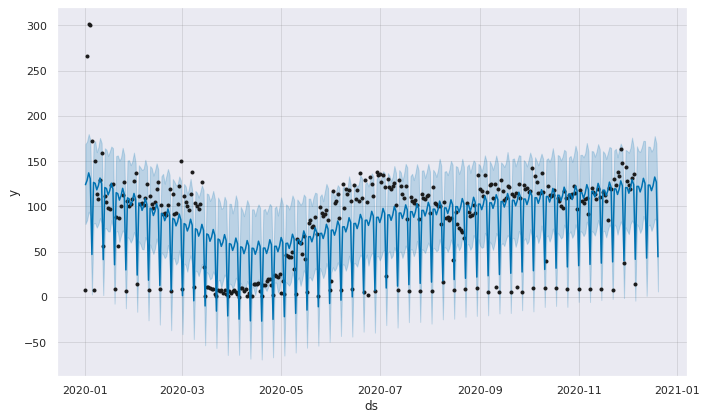

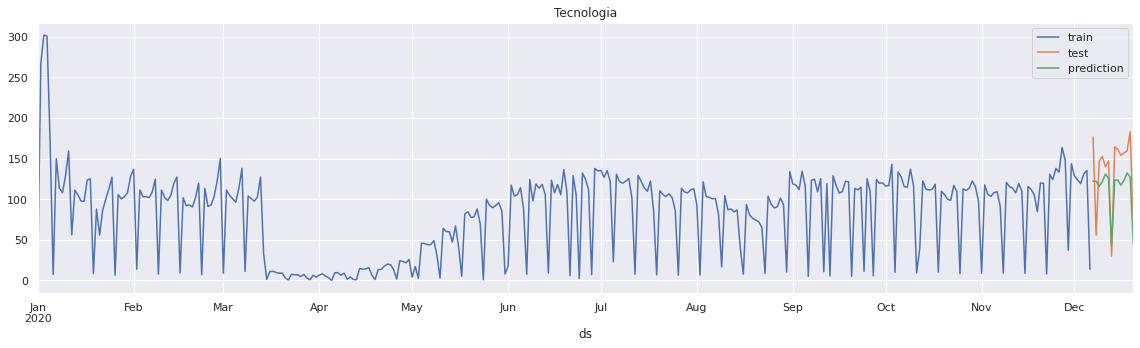

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAPE: 31.13
RMSE: 38.02


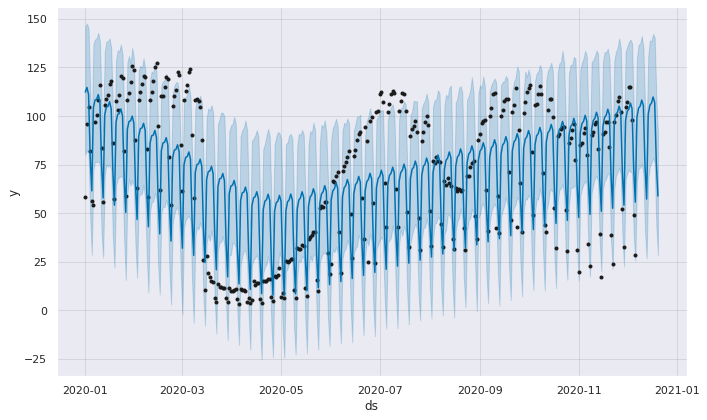

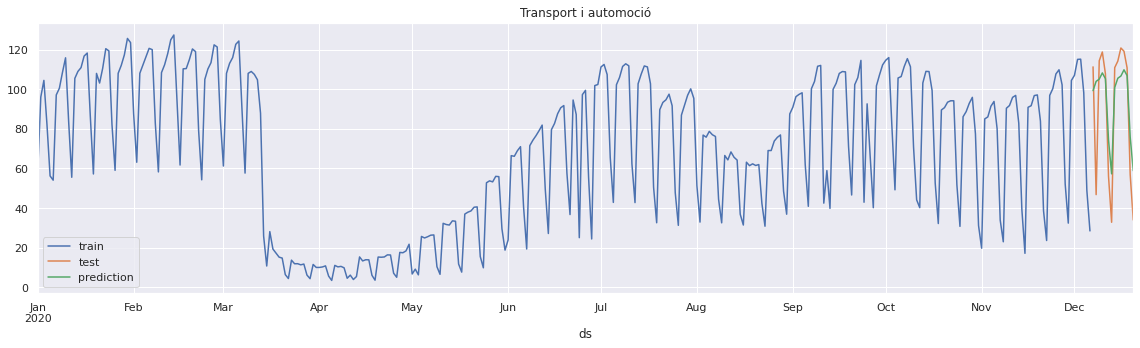

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAPE: 28.98
RMSE: 20.72


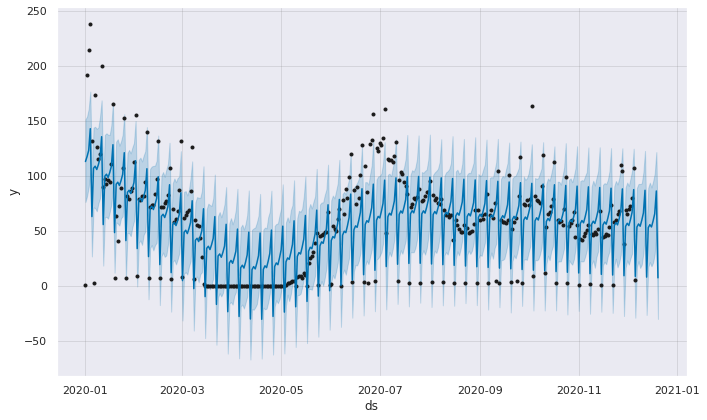

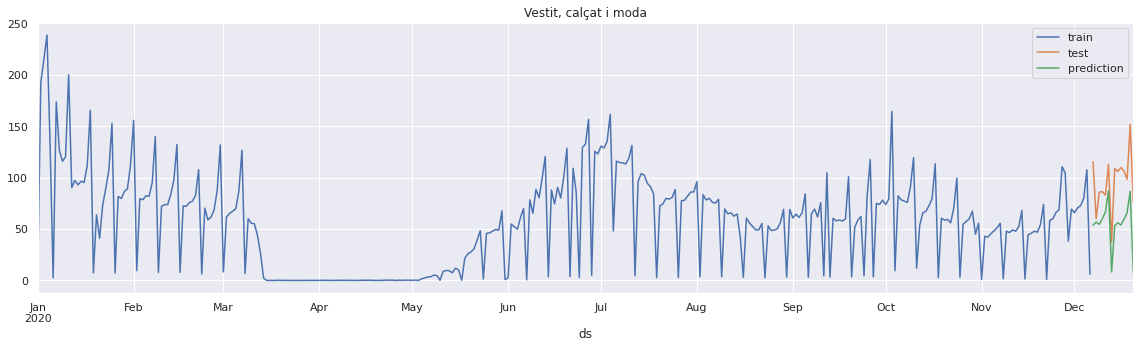

MAPE: 43.26
RMSE: 44.80


In [ ]:
# dictionaries to save the results and predictions
dict_pred_prophet = {}
l_prophet = []

# iterate by different modes of transport
for sector in list(df_agg.index.levels[1]):
  start_time = time.time()
  ts = df_agg.xs(sector, level=1)
  ts.reset_index(inplace=True)
  # column names need to be ds for the date and y for the target
  ts.columns = ['ds','y']

  # split the time series in train and test sets
  train = ts.iloc[:-DAYS]
  test = ts.iloc[-DAYS:]

  # creating the model
  m = Prophet()
  m.fit(train)
  future = m.make_future_dataframe(periods=DAYS,freq='D')
  forecast = m.predict(future)
  m.plot(forecast)

  forecast.set_index('ds', inplace=True)
  # filtering only future predictions
  predictions = forecast.loc[test['ds'].min():,'yhat']

  train.set_index('ds', inplace=True)
  test.set_index('ds', inplace=True)

  # plot the results
  fig, ax = plt.subplots(1,1, figsize=(16,5))
  train['y'].plot(label='train', ax=ax)
  test['y'].plot(label='test', ax=ax)
  predictions.plot(label='prediction', ax=ax)
  ax.set(title=sector)
  plt.legend()
  plt.tight_layout()
  plt.show()

  # evaluating the model
  mape, rmse_result = error_ts(test.values.flatten(), predictions.values.flatten())
  print("="*20)

  dict_pred_prophet[sector] = (predictions, [mape, rmse_result])
  l_prophet.append(time.time() - start_time)
dict_times['prophet'] = l_prophet

In [ ]:
# dictionary with mape and rsme
dict_results_prophet = {}
for sector in dict_pred_prophet.keys():
    dict_results_prophet[sector] = dict_pred_prophet[sector][1]
    
df_results_prophet = pd.DataFrame(dict_results_prophet).T.rename(columns={0: 'MAPE', 1:'RMSE'})
df_results_prophet.sort_values(by='MAPE', inplace=True)
df_results_prophet = df_results_prophet.add_suffix('_prophet')

The results of Prophet:

In [ ]:
df_results_prophet

MAPE_prophet  RMSE_prophet
Serveis turístics i de restauració        9.133913      8.812528
Béns i serveis de primera necessitat     14.241743     21.428802
Resta béns i serveis                     25.612236     41.722857
Transport i automoció                    28.984351     20.718089
Cultura, lleure i esports                29.151270     59.125383
Tecnologia                               31.129818     38.015264
Vestit, calçat i moda                    43.264408     44.800825

# EVALUATION

In this section, I summarize the results we have obtained with all the models.

In [ ]:
# joining the results in a same dataframe
df_results_full = pd.merge(df_results, df_results_ml, left_index=True, right_index=True)
df_results_full = pd.merge(df_results_full, df_results_lstm, left_index=True, right_index=True)
df_results_full = pd.merge(df_results_full, df_results_prophet, left_index=True, right_index=True).reset_index()
df_results_full

index  ...  RMSE_prophet
0    Serveis turístics i de restauració  ...      8.812528
1  Béns i serveis de primera necessitat  ...     21.428802
2                 Transport i automoció  ...     20.718089
3                  Resta béns i serveis  ...     41.722857
4             Cultura, lleure i esports  ...     59.125383
5                            Tecnologia  ...     38.015264
6                 Vestit, calçat i moda  ...     44.800825

[7 rows x 9 columns]

In [ ]:
# preparing data to plot
df_melted = pd.melt(frame=df_results_full, id_vars='index',
        value_vars=list(df_results_full.columns)[1:],
       var_name='metric').rename(columns={'index': 'mode'})
df_melted.head()

mode       metric      value
0    Serveis turístics i de restauració  MAPE_sarima   7.391593
1  Béns i serveis de primera necessitat  MAPE_sarima  11.750629
2                 Transport i automoció  MAPE_sarima  15.873975
3                  Resta béns i serveis  MAPE_sarima  16.065712
4             Cultura, lleure i esports  MAPE_sarima  17.543530

We use the metrics to evaluate the models by sector:

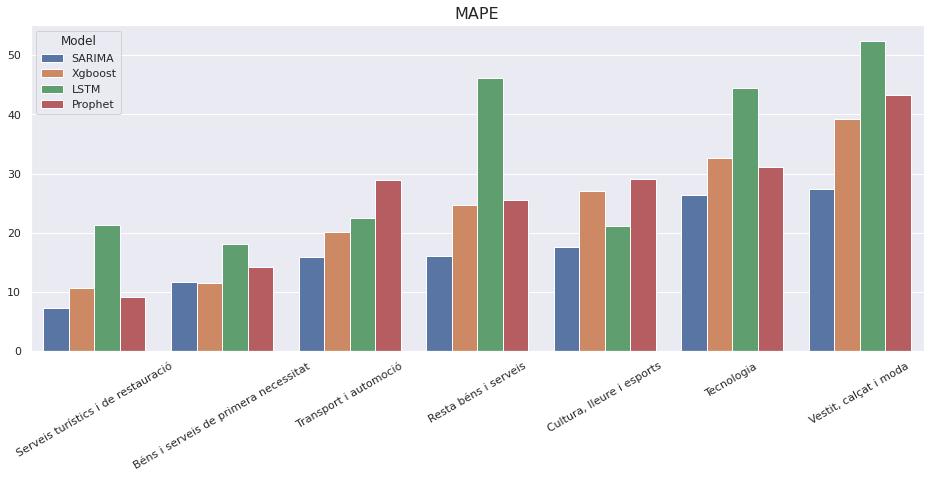

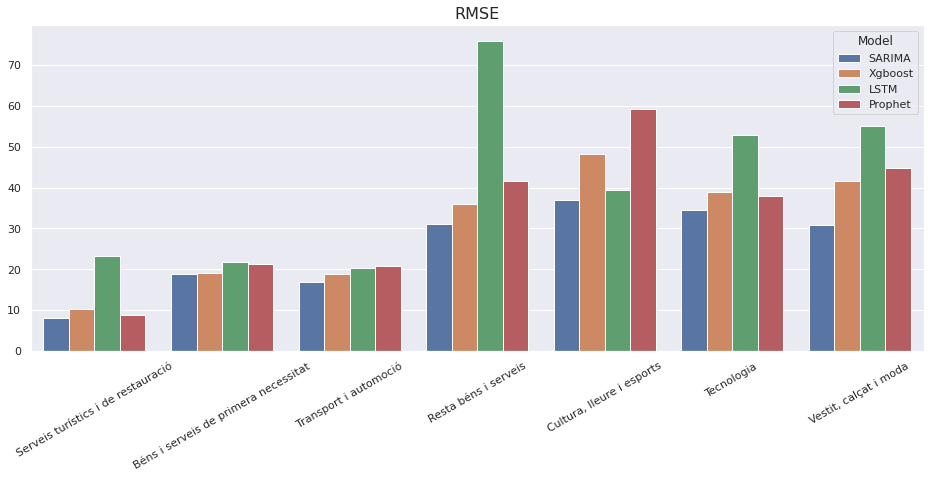

In [ ]:
def plot_results(metric):

  fig, ax = plt.subplots(1,1, figsize=(16,6))
  sns.barplot(data=df_melted.loc[df_melted['metric'].str.contains(metric)],
            x='mode', y='value', hue='metric', ax=ax)
  
  ax.set_title(metric,fontsize=16)
  ax.set(xlabel="", ylabel="")
  ax.legend(title='Model')

  # replacing legend labels
  new_labels = ['SARIMA', 'Xgboost', 'LSTM', 'Prophet']
  leg = ax.get_legend()
  for t, l in zip(leg.texts, new_labels): 
    t.set_text(l)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=30)

  return None

plot_results('MAPE')
plot_results('RMSE')

Plotting a boxplot of the models used we can see which ones perform better:

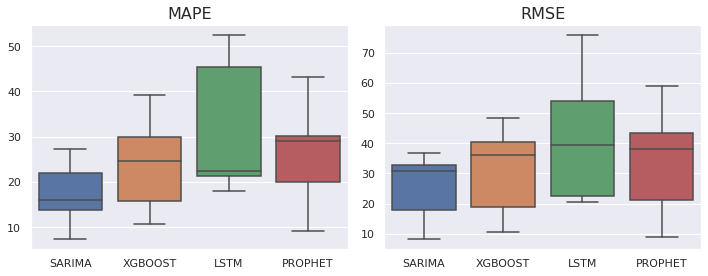

In [ ]:
def plot_boxplot(metric, ax):
  # filter by metric
  df = df_melted.loc[df_melted['metric'].str.contains(metric)]
  # removes name of the metric from the beginning and makes uppercase
  df['metric'] = df['metric'].str.replace(f"{metric}_", "").str.upper()
  sns.boxplot(data=df, x='metric', y='value', ax=ax)
  ax.set_title(metric,fontsize=16)
  ax.set(xlabel="", ylabel="")
  plt.tight_layout();

fig, ax = plt.subplots(1,2, figsize=(10,4))

plot_boxplot('MAPE', ax[0])
plot_boxplot('RMSE', ax[1])

And the execution times by model:

In [ ]:
df_times.mean()

sarima      65.524088
xgboost      1.060137
lstm       396.903374
prophet      4.078150
dtype: float64

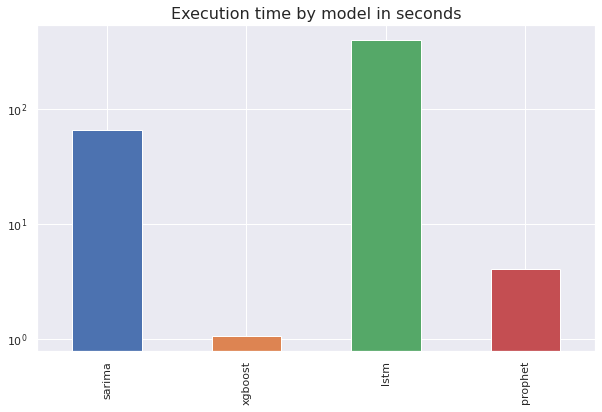

In [ ]:
df_times = pd.DataFrame(dict_times)
ax = df_times.mean().plot.bar(figsize=(10,6), color=sns.color_palette())
ax.set_yscale('log')
ax.set_title("Execution time by model in seconds", fontsize=16)
ax.set_ylabel("");

Finally, for each commercial sector, I choose the model that obtains the best MAPE in the test set:

In [ ]:
df_results_full.set_index('index', inplace=True)
best_models = df_results_full.loc[:, df_results_full.columns.str.startswith('MAPE')].idxmin(axis=1)
best_mape = df_results_full.loc[:, df_results_full.columns.str.startswith('MAPE')].min(axis=1)

print("Best model by sector:\n")
for model, mape in zip(best_models.iteritems(), best_mape.iteritems()):
  print(f"{model[0]}: {model[1].replace('MAPE_','')}, MAPE: {mape[1]:.2f} %")

print(f"\n\nThe average MAPE is: {best_mape.mean():.2f} %")

Best model by sector:

Serveis turístics i de restauració: sarima, MAPE: 7.39 %
Béns i serveis de primera necessitat: xgboost, MAPE: 11.60 %
Transport i automoció: sarima, MAPE: 15.87 %
Resta béns i serveis: sarima, MAPE: 16.07 %
Cultura, lleure i esports: sarima, MAPE: 17.54 %
Tecnologia: sarima, MAPE: 26.40 %
Vestit, calçat i moda: sarima, MAPE: 27.34 %


The average MAPE is: 17.46 %


Average MAPE:

# FORECASTING

In this section, **I forecast the future with the best model for each sector**. This time I use **all available data**:

In [ ]:
dict_fcast = {}

# iterating by commercial sector
for sector, fcast_model in best_models.iteritems():
  ts = df_agg.xs(sector, level=1)

  # new emtpy series with future dates as index
  ts_predict = pd.Series(np.zeros(DAYS), index=pd.date_range(
    ts.index.max()+datetime.timedelta(days=1), periods=DAYS, freq='D'))
  
  if fcast_model == 'MAPE_sarima':
    # recovering sarima orders
    order = dict_order_sar[sector][0]
    seasonal_order = dict_order_sar[sector][1]

    model = SARIMAX(ts, order=order, seasonal_order=seasonal_order)
    results = model.fit()

    # new predictions
    start=len(ts)
    end=len(ts)+DAYS-1
    fcast = results.predict(start=start, end=end, dynamic=False, typ='levels')

    dict_fcast[sector] = fcast

  elif fcast_model == 'MAPE_xgboost':

    ts = pd.concat([ts, ts_predict.to_frame().rename(columns={0:'Valor'})])
    # adding features
    ts['month'] = ts.index.month
    ts['day'] = ts.index.day
    ts['week'] = ts.index.isocalendar().week
    ts['week_day'] = ts.index.weekday
    ts['week'] = ts['week'].astype('int')

    train = ts.iloc[:-DAYS]
    pred = ts.iloc[-DAYS:]

    X_train, y_train = train.drop('Valor', axis=1), train['Valor']
    X_test = pred.drop('Valor', axis=1)

    model = xgb.XGBRegressor(random_state=42).fit(X_train, y_train)
    predictions = model.predict(X_test)

    fcast = pd.Series(predictions, index=pred.index)
    dict_fcast[sector] = fcast

  elif fcast_model == 'MAPE_lstm':
    scaler = MinMaxScaler()
    scaled_train = scaler.fit_transform(ts)

    generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

    model = dict_keras_models[sector]
    history = model.fit(generator, epochs=50, verbose=0) 

    fcast = rnn_predictions(ts_predict, scaled_train, model, scaler)
    dict_fcast[sector] = fcast

  else:
    ts.reset_index(inplace=True)
    ts.columns = ['ds','y']

    m = Prophet()
    m.fit(ts)
    future = m.make_future_dataframe(periods=DAYS,freq='D')
    forecast = m.predict(future)

    forecast.set_index('ds', inplace=True)
    fcast = forecast.iloc[-DAYS:, -1]
    dict_fcast[sector] = fcast

  print(f"{sector} forecasted")

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Serveis turístics i de restauració forecasted
[15:38:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Béns i serveis de primera necessitat forecasted
Transport i automoció forecasted


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Resta béns i serveis forecasted
Cultura, lleure i esports forecasted
Tecnologia forecasted
Vestit, calçat i moda forecasted


Then we plot the forecast where I assign a colour to each sector:

In [ ]:
cat = df_agg.index.levels[1].unique()
n_cat = len(cat)
line_colors = sns.color_palette('Dark2', n_colors=n_cat, as_cmap=True).colors
cat_feat = {}
for x, y in zip(cat, line_colors):
  cat_feat[x] = [y]

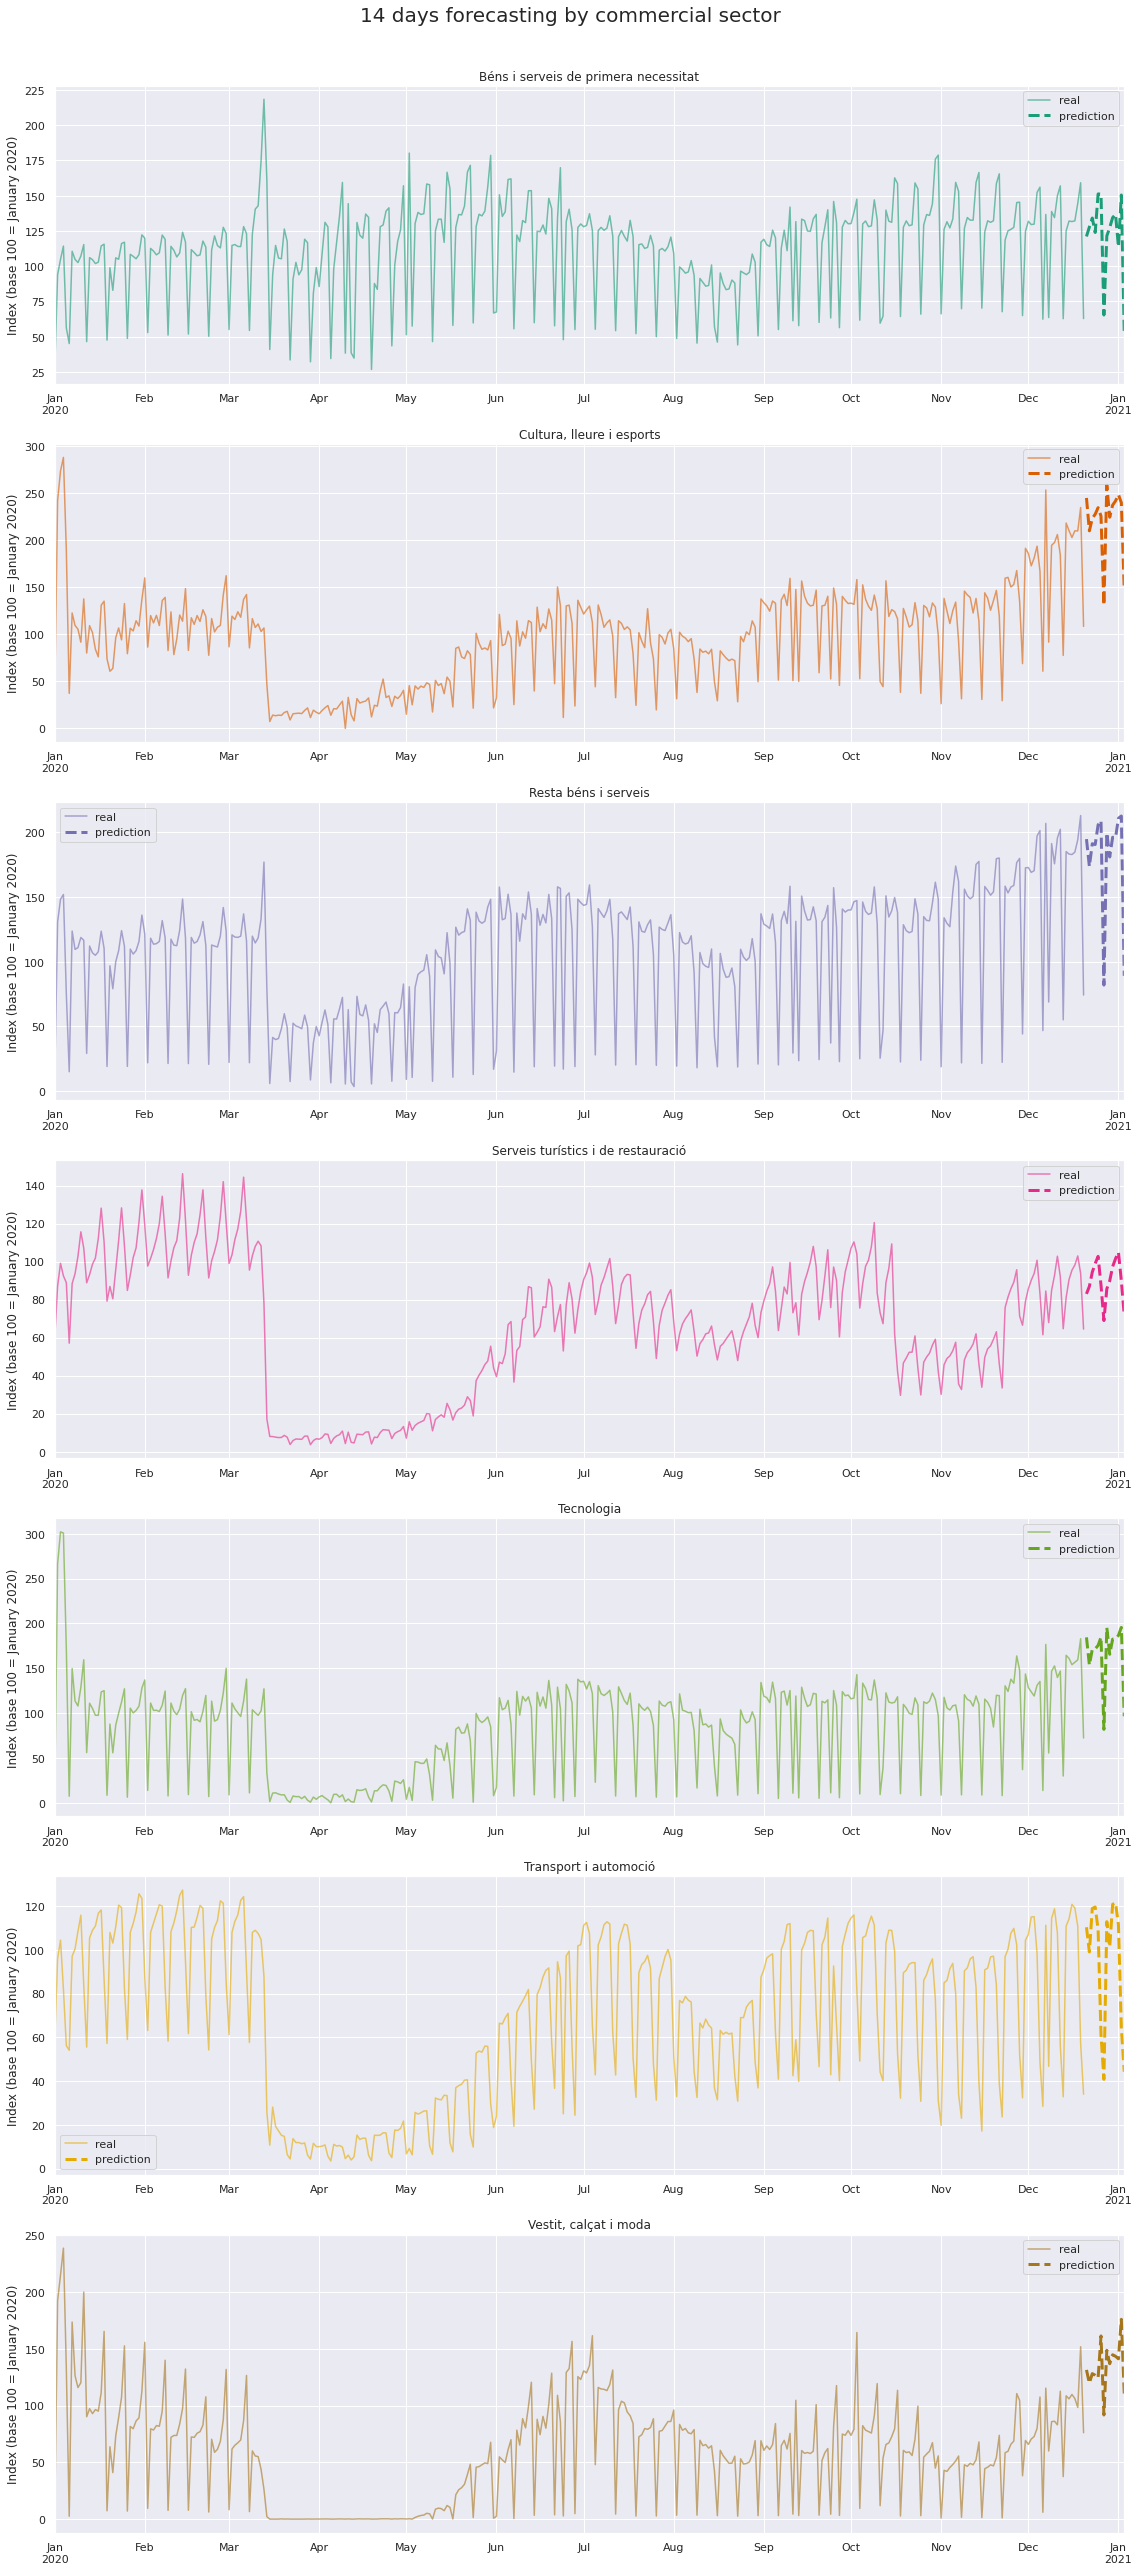

In [ ]:
fig, ax = plt.subplots(7, 1, figsize=(16,35))

for i, sector in enumerate(cat):
  ts = df_agg.xs(sector, level=1)
  ts.rename(columns={"Valor": "real"}, inplace=True)
  ts.plot(color=cat_feat[sector], alpha=0.6, ax=ax[i])
  dict_fcast[sector].plot(color=cat_feat[sector], label='prediction', linestyle='--', linewidth=3, ax=ax[i])
  ax[i].set(title=sector, xlabel="", ylabel="Index (base 100 = January 2020)")
  ax[i].legend()

fig.suptitle(f"{DAYS} days forecasting by commercial sector", fontsize=20, y=1.02)
plt.tight_layout()

The plot below uses the forecast data to calculate a moving average:

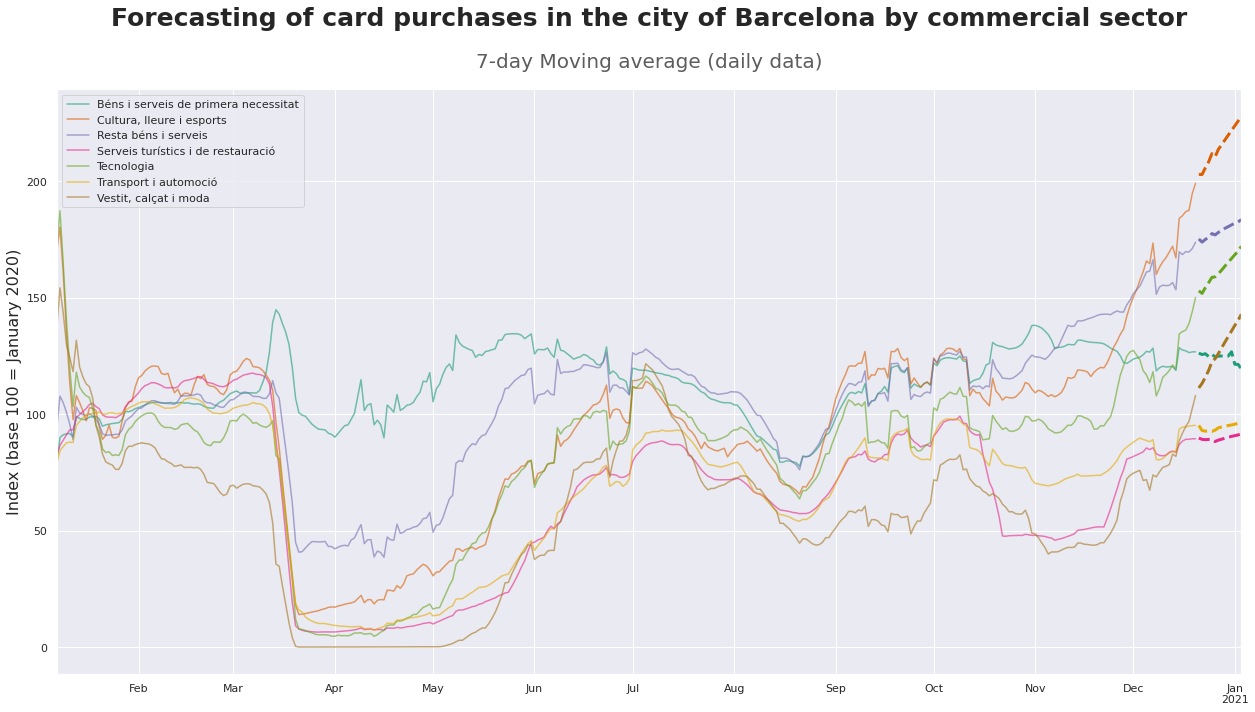

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(18,10))
window = 7 # select the periods to include in the window

for sector in cat:
  ts = df_agg.xs(sector, level=1).iloc[:,0] # filtering by sector
  pred = dict_fcast[sector]
  ts_full = ts.append(pred)
  ts_roll = ts_full.rolling(window=window, min_periods=window).mean().dropna()
  ts_roll.rename(sector, inplace=True)
  ts_roll.loc[ts_roll.index <= f_date].plot(color=cat_feat[sector], alpha=0.6, ax=ax)
  ts_roll.loc[ts_roll.index > f_date].plot(label="_nolegend_",
                  color=cat_feat[sector],ax=ax, linestyle='--', linewidth=3)

ax.text(x=0.5, y=1.1, s="Forecasting of card purchases in the city of Barcelona by commercial sector",
      fontsize=25, weight='bold', ha='center', va='bottom',
      transform=ax.transAxes)
ax.text(x=0.5, y=1.03, s=f"{window}-day Moving average (daily data)",
      fontsize=20, alpha=0.75, ha='center', va='bottom', transform=ax.transAxes)
ax.legend(title='Commercial sector')
plt.ylabel('Index (base 100 = January 2020)', fontsize=16)

plt.legend()
plt.tight_layout()

# CONCLUSIONS

* After training several models like SARIMA, Gradient Boosting, LSTM and Prophet to forecast credit card purchases by commercial sector, we have achieved an **average MAPE of 17 %**, taking into account all sectors. Notice there are sectors that have been much easier to forecast than others, for example, we got very good results in *Serveis turístics i de restauració*, MAPE= 7 %, and not so good in *Vestit, calçat i moda*. 

* Furthermore, regarding the performance of the models, the one with the **lowest MAPE in average is SARIMA** and it has the lower variance too, whereas the model with the **highest MAPE is Prophet**.

* Regarding the computational cost, the most expensive is the LSTM which takes approximately 370 times longer than Xgboost which is the fastest, while SARIMA model takes only 60 times longer than Gradient Boosting.

* Finally, we carried out **predictions of the future for the next 14 days** to forecast the trend of each sector separately. It can be seen that sectors like *Cultura, lleure i esports*, *Resta béns i serveis* and *Tecnlogia*, *Vestit, calçat i moda* have an **upward trend** and sectors like *Béns i serveis de primera necesitat*, *Transport i automoció* and *Serveis turístics i de restauració* remain approximately stationary.